In [137]:
import numpy as np
import pylab as pl
import pandas as pd
from scipy import stats as S
from scipy.spatial import distance as D 
from tqdm import tqdm
import re
import time
import os
import pickle


%matplotlib inline


from tm_python_lib import *
from fitting_tools import *
from adaptive_kernel_tom import adaptive_kernel_quantile_pdf_tom


In [3]:
fig_width_pt = 420.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width  # *golden_mean      # height in inches
fig_size = [fig_width, fig_height]


params = {'backend': 'ps',
          'axes.labelsize': 25,
          #'text.fontsize': 32,
          'legend.fontsize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': False,
          'figure.figsize': fig_size}
pl.rcParams.update(params)


In [138]:
def rankorder(x):
    x1 = list(np.sort(x))
    x1.reverse()
    y1 = range(1,len(x1)+1)
    return np.array(x1),np.array(y1)


def logify(x,y):
	from numpy import log10
	c = (x>0)*(y>0)
	lx = log10(x[c])
	ly = log10(y[c])
	return lx,ly


def binning(x,y,bins,log_10=False,confinter=5):
    '''makes a simple binning'''

    x = np.array(x);y = np.array(y)

    if isinstance(bins,int) or isinstance(bins,float):
        bins = np.linspace(np.min(x)*0.9,np.max(x)*1.1,bins)
    else:
        bins = np.array(bins)

    if log_10:
        bins = bins[bins>0]
        c = x > 0
        x = x[c]
        y = y[c]
        bins = np.log10(bins)
        x = np.log10(x)
        y = np.log10(y)

    Tbins = []
    Median = []
    Mean = []
    Sigma =[]
    Perc_Up = []
    Perc_Down = []
    Points=[]


    for i,ix in enumerate(bins):
        if i+2>len(bins):
            break

        c1 = x >= ix
        c2 = x < bins[i+1]
        c=c1*c2

        if len(y[c])>0:
            Tbins = np.append(Tbins,np.median(x[c]))
            Median =  np.append(Median,np.median(y[c]))
            Mean = np.append(Mean,np.mean(y[c]))
            Sigma = np.append(Sigma,np.std(y[c]))
            Perc_Down = np.append(Perc_Down,np.percentile(y[c],confinter))
            Perc_Up = np.append(Perc_Up,np.percentile(y[c],100 - confinter))
            Points = np.append(Points,len(y[c]))


    return {'bins' : Tbins,
            'median' : Median,
            'mean' : Mean,
            'stdDev' : Sigma,
            'percDown' :Perc_Down,
            'percUp' :Perc_Up,
            'nPoints' : Points}



In [201]:
# Data Preparation
def extract_data(filename,sdg=False,save=False):     
    df = pd.read_csv(filename)
    
    if sdg:
        df = df[df['is_sdg_related']=="yes"]
        suffix = "sdg"
    else:
        df = df[df['is_sdg_related']=="no"]
        suffix = "no_sdg"
                     
    #Load and clean data:
    df = pd.read_csv(filename)
    df = df.drop_duplicates()
    df['number_participants_per_project']= df['participants_vector'].str.len()
    df = df.sort_values(['start_timestamp'],ascending=[True])
    df['datetime'] = pd.to_datetime(df['start_timestamp'],format='%Y-%m-%d' )

    # Extract all Participants:
    array_participants = df['participants_vector'].values
    array_hackathons = df['hackathonID'].values
    array_hack_timestamp = df['start_timestamp'].values

    participants = []
    hackathons = []
    dates = []
    for p,px in enumerate(array_participants):
        #print(p,px)
        try:
            participants_hack = px.split(",")
            replicate_hack = [array_hackathons[p]]*len(participants_hack)
            replicate_date = [array_hack_timestamp[p]]*len(participants_hack) 

            participants += participants_hack
            hackathons += replicate_hack
            dates += replicate_date
        except:
            continue


    print(len(hackathons),len(participants))

    ### Prepare DataFrame with Participant Information:
    df_hack_participants = pd.DataFrame(np.array([hackathons,participants,dates]).transpose(),columns=['hackathonID','participantID','timestamp'])

    participation_increment = np.zeros(len(participants))
    u_participants = np.unique(participants)

    for i,ix in tqdm(enumerate(u_participants)):
        index = df_hack_participants[df_hack_participants['participantID']==ix].index
        increments = range(1,1+len(index))
        participation_increment[index]=increments

    df_hack_participants['participation_increment'] = participation_increment
    

    df_hack_participants.to_pickle("data/df_hack_participants_%s.pkl"%suffix)
    df_hack_participants['timestamp'] = pd.to_datetime(df_hack_participants['timestamp'],format='%Y-%m-%d' )
    df_hack_participants['datetimeindex'] = pd.DatetimeIndex(df_hack_participants['timestamp'])


    ### Prepare DataFrame with Hack Dates:
    df_hack_time = df_hack_participants[['hackathonID','timestamp']].drop_duplicates()
    df_hack_time['datetimeindex'] = pd.DatetimeIndex(df_hack_time['timestamp'])


    ### Prepare DataFrame with Repos Data:
    array_projects = df['projectID'].values
    array_repos = df['githubURL_proj'].values 
    hackathons = []
    projects = []
    repos = []
    dates = []

    for r,rx in enumerate(array_repos):
        try:
            repos_hack = rx.split(",")
            replicate_hack = [array_hackathons[r]]*len(repos_hack)
            replicate_project = [array_projects[r]]*len(repos_hack)
            replicate_date = [array_hack_timestamp[r]]*len(repos_hack) 

            repos += repos_hack
            hackathons += replicate_hack
            projects += replicate_project
            dates += replicate_date
        except:
            continue


    print(len(hackathons),len(repos))
    df_hack_repos = pd.DataFrame(np.array([hackathons,projects,repos,dates]).transpose(),columns=['hackathonID','projectID','repoURL','timestamp'])
    df_hack_repos['repoID'] = df_hack_repos['repoURL'].str.replace(r'.*?github.com/', '', regex=True)

    if save:
        df.to_pickle("data/df_%s.pkl"%suffix)
        df_hack_participants.to_pickle("data/df_hack_participants_%s.pkl"%suffix)
        df_hack_time.to_pickle("data/df_hack_time_%s.pkl"%suffix)
        df_hack_repos.to_pickle("data/df_hack_repos_%s.pkl"%suffix)

    return {'df':df, 'df_hack_repos': df_hack_repos,'df_hack_participants':df_hack_participants,'df_hack_time':df_hack_time}



def prepare_github_activity(dir,save=False):
    '''Concatenate data from Github Archive (through Google BigQuery) to a dataframe'''
    files = os.listdir(dir)
    li = []

    for file in files:
        df = pd.read_csv(dir + file, index_col=None, header=0)
        li.append(df)

    df_github = pd.concat(li, axis=0, ignore_index=True)
    df_github = df_github.rename(columns={'name': 'repoID', 'f0_': 'count','type':'type_event'})
    if save:
        df_github.to_pickle("%s.pkl"%dir)

    return df_github  

In [198]:
df_all = pd.read_pickle("data/df_all.pkl ")

In [202]:
#Prepare Devpost Data
filename = "data/data_ensemble_SDG_with_repos.csv"
data_frames = extract_data(filename,sdg=False,save=True)
data_frames_sdg = extract_data(filename,sdg=True,save=True)

464123 464123


335222it [2:47:29, 33.36it/s]


112825 112825
464123 464123


335222it [4:49:08, 19.32it/s]


112825 112825


### Load Data & Retrieve data from GitHub

In [205]:
dicDF = {}

for suffix in ['no_sdg','sdg']:
        dicDF['df_%s'%suffix] = pd.read_pickle("data/df_%s.pkl"%suffix)
        dicDF['df_hack_participants_%s'%suffix] = pd.read_pickle("data/df_hack_participants_%s.pkl"%suffix)
        dicDF['df_hack_time_%s'%suffix] = pd.read_pickle("data/df_hack_time_%s.pkl"%suffix)
        dicDF['df_hack_repos_%s'%suffix] = pd.read_pickle("data/df_hack_repos_%s.pkl"%suffix)
        dicDF['df_github_%s'%suffix] = pd.read_pickle("data/df_github_%s.pkl"%suffix)


In [ ]:
#Randomize and Export X repos 
save = False
randomized_sample = df_hack_repos['repoID'].unique()
np.random.shuffle(randomized_sample)
#df_rand_sample = pd.DataFrame(randomized_sample[:1000]) 
#df_rand_sample.to_csv("test.csv", header=False, index=False, line_terminator='')

if save:
    export = "','".join(list(randomized_sample[:10000]))
    f = open("export_repo_list_%s.txt"%time.strftime("%Y%m%d-%H%M%S"),'w')
    f.write("'" + export + "'")
    f.close

### Plot Github Activity Response 

In [154]:
def stacked_hack_activity(github_df_name,vicinity_range = np.arange(-20,100),plot=True,return_dic=False):

    try:  #load data from dictionary:
        with open("data/dic_plot_%s.pkl"%github_df_name, 'rb') as handle:
            dic = pickle.load(handle)
        #print("dic loaded")
    except: #load dataframe for processing
        print("failed to load dic. Processing with dataframe")
        df_github = pd.read_pickle("data/%s.pkl"%github_df_name)
        df_hack_repos = pd.read_pickle("data/df_hack_repos_%s.pkl"%github_df_name[-3:])
        # Initialize variables
        repos = df_github['repoID'].unique()
        Delta_Days = np.array([])
        Count_Events = np.array([])
        Count_Events_Normalized = np.array([])
        Dates = []
        Delta_Days_Creation = np.array([]) 
        Repos2 = np.array([])
        Repos3 = np.array([])
        
        #li = []
        #vicinity_range = np.arange(-20,100)
        vicinity = np.zeros_like(vicinity_range)

        repos_created_during_hack = 0
        repos_created_in_vicinity_of_hack = 0 # within a +/- 3 days range


        for repo in tqdm(repos[:]):
            df_test= df_github[df_github['repoID']==repo].groupby(["Date"]).count()['type_event']
            df_test.index = pd.to_datetime(df_test.index)
            dates = pd.to_datetime(df_hack_repos[df_hack_repos['repoID'] == repo]['timestamp'].values)
            Dates = Dates + list(dates)            

            for d,dx in enumerate(dates):
                
                delta_days = (df_test.index-dx).days.values
                count_events = df_test.values
                delta_days_creation = [(df_test.index.min()-dx).days]*len(df_test)
                index_max = np.argmax(count_events)
                index_0 = np.argwhere(np.abs(delta_days)<=3)
                index_intersect = np.intersect1d(index_max,index_0)
                #print("index max: %s, dt_days: %s, count_events: %s, intersect: %s"%(index_max,delta_days[index_max],count_events[index_max],index_intersect))


                for v,vx  in enumerate(vicinity_range):
                    if delta_days[0] == vx: vicinity[v] += 1             
                
                if len(index_intersect) == 0 or len(count_events) == 1:
                    continue
                #else:
                    #print("index: %s, delta_days : %s, count_events: %s"%(index_intersect,delta_days[index_intersect],count_events[index_intersect]))
                #try:   
                #    #index_0 = np.argwhere(delta_days==1)[0]
                #    index_0 = np.argmax(count_events)
                #    print("index : %s"%index_0)#,index_max)
                #except:
                #    continue
                
                #print(index_0)

                
                if d == 0: # take only the first date, ignore subsequent dates
                    #Delta_Days_Creation = np.append(Delta_Days_Creation,(df_test.index.min()-dx).days)
                    Delta_Days_Creation = np.append(Delta_Days_Creation,delta_days_creation)
                    Repos2 = np.append(Repos2,repo)

                    Delta_Days = np.concatenate([Delta_Days,delta_days])
                    Count_Events = np.concatenate([Count_Events,count_events])
                    #print(count_events/count_events[index_intersect])
                    Count_Events_Normalized = np.concatenate([Count_Events_Normalized,count_events/count_events[index_intersect]])




        dic = {'Repos' : repos, 'Repos2' : Repos2 ,'Dates' : Dates, 'Delta_Days_Creation': Delta_Days_Creation,'Delta_Days':Delta_Days, 'Count_Events': Count_Events,'Count_Events_Normalized':Count_Events_Normalized ,'vicinity_range':vicinity_range, 'vicinity' : vicinity}

        '''
        #To do : determine the optimal t_c        
        tc_range = np.linspace(-5,5,100)
        t_max_range =  np.linspace(50,100,20)

        for t_max in t_max_range:
            for tc in tc_range:
                x = dic['vicinity_range']-tc
                y = dic['vicinity']

                cond = x < t_max                

                lx,ly = logify(x[cond],y[cond])
                B = binning(lx,ly,20)

                fitB = S.linregress(B['bins'],B['mean'])

                print(f"fit : tmax:{t_max:7.2f},tc:{tc:7.2f}, slope:{fitB.slope:7.2f}, p:{fitB.pvalue:7.2f}, rvalue:{fitB.rvalue:7.2f}") 

        '''
        
 
        with open("data/dic_plot_%s.pkl"%github_df_name, 'wb') as handle:
            pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

    '''
    if plot: 

        tc_range = np.arange(-2,7,0.1)
        t_max_range =  np.arange(50,302,2)

   
        for tc in tc_range:
            for t_max in t_max_range:

                x = dic['vicinity_range']-tc
                y = dic['vicinity']

                cond = x < t_max                

                lx,ly = logify(x[cond],y[cond])
                B = binning(lx,ly,20)

                fitB = S.linregress(B['bins'],B['mean'])

                if np.abs(fitB.rvalue) > 0.94 and fitB.pvalue < 10**-6:
                    #print(tc)
                    print(f"fit : tmax:{t_max:.2f},tc:{tc:.2f}, slope:{fitB.slope:.2f}, p:{fitB.pvalue:.3f}, rvalue:{fitB.rvalue:.5f}")        
    '''
 



    if return_dic : return dic

dic_all = stacked_hack_activity("df_github_all",vicinity_range = np.arange(-100,300),return_dic=True) 
dic_sdg = stacked_hack_activity("df_github_sdg",vicinity_range = np.arange(-100,300),return_dic=True)

failed to load dic. Processing with dataframe


100%|██████████| 8051/8051 [02:49<00:00, 47.41it/s]


[0.30103 0.30103 0.30103 ... 0.      0.      0.     ]
LinregressResult(slope=-0.24356060637127974, intercept=2.297014622667969, rvalue=-0.5475103442730199, pvalue=0.018677601110676303, stderr=0.09306273986461348, intercept_stderr=0.1871441285306313)


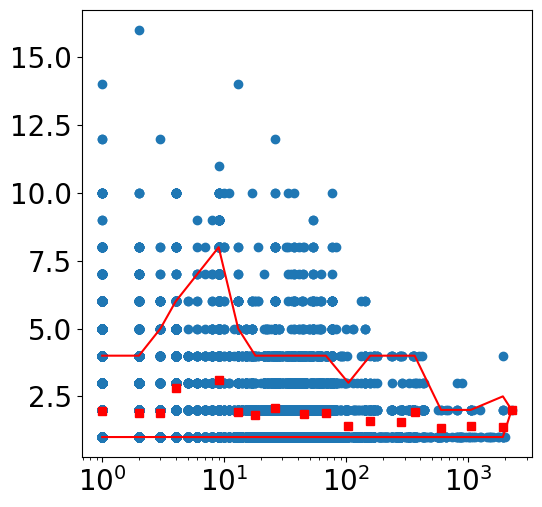

In [413]:
# Some old stuff 

x = df_dt_days_creation['delta_days_creation'].values
y = df_dt_days_creation['count_events'].values
z = df_dt_days_creation['delta_days'].values
c = (x>0)#*(z<5)#*(x>-3000)

lx = np.log10(x[c])
print(lx)
B = binning(lx,y[c],20,confinter=5)
fitB = S.linregress(B['bins'],B['mean'])  
print(fitB)
pl.semilogx(x[c],y[c],'o')
pl.semilogx(10**B['bins'],(B['mean']),'rs')
pl.semilogx(10**B['bins'],(B['percUp']),'r-')
pl.semilogx(10**B['bins'],(B['percDown']),'r-')

In [207]:
# Some old stuff

x = df_dt_days_creation['delta_days_creation'].values
y = df_dt_days_creation['count_events'].values
z = df_dt_days_creation['delta_days'].values
c = (x<0)*(x>-2000)#*(z>-2)*(z<2)


lx = np.log10(-x[c])

B = binning(lx,y[c],20)
fitB = S.linregress(B['bins'],B['mean'])  
print(fitB)
pl.semilogx(-x[c],y[c],'o')
pl.semilogx(10**B['bins'],(B['mean']),'rs')
#pl.semilogx(10**B['bins'],(B['percUp']),'r-')


LinregressResult(slope=0.349663406508664, intercept=2.067558805773074, rvalue=0.36667372457845865, pvalue=0.13447501937288614, stderr=0.22179746519385804, intercept_stderr=0.43676525587240184)


Error in callback <function flush_figures at 0x169c2b3a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

fit B repoCreations:  LinregressResult(slope=-0.7924458751541867, intercept=2.011811019390046, rvalue=-0.9233113746563312, pvalue=9.837186147607529e-13, stderr=0.0634351275992806, intercept_stderr=0.09669976596817066)
fit repoCreations:  LinregressResult(slope=-0.9331942162678678, intercept=2.2491362826481, rvalue=-0.849124579180722, pvalue=9.096620926152951e-47, stderr=0.04560741440806709, intercept_stderr=0.08642522371920403)


'\npl.figure(3,(13,10)) # Before peak\nx = dic[\'vicinity_range\'] - 1 + 1.5\ny = dic[\'vicinity\'] \n\nc = (x < 0)*(x>-40)\n\nlx,ly = logify(-x[c],y[c])\nB = binning(lx,ly,20)\n#x_cutoff = np.argwhere(B[\'mean\'] < 2)[-1][0]\n\n\nfitB = S.linregress(B[\'bins\'][:x_cutoff],B[\'mean\'][:x_cutoff])\nprint("fit B repoCreations: ", fitB)\nfit = S.linregress(lx,ly)\nprint("fit repoCreations: ", fit)\npl.loglog(-x,y,\'.\')\npl.loglog(10**(B[\'bins\']),10**(B[\'mean\']),\'rs\')\npl.loglog(10**(B[\'bins\']),10**(B[\'bins\']*fitB[0]+fitB[1]),\'r-\')\n'

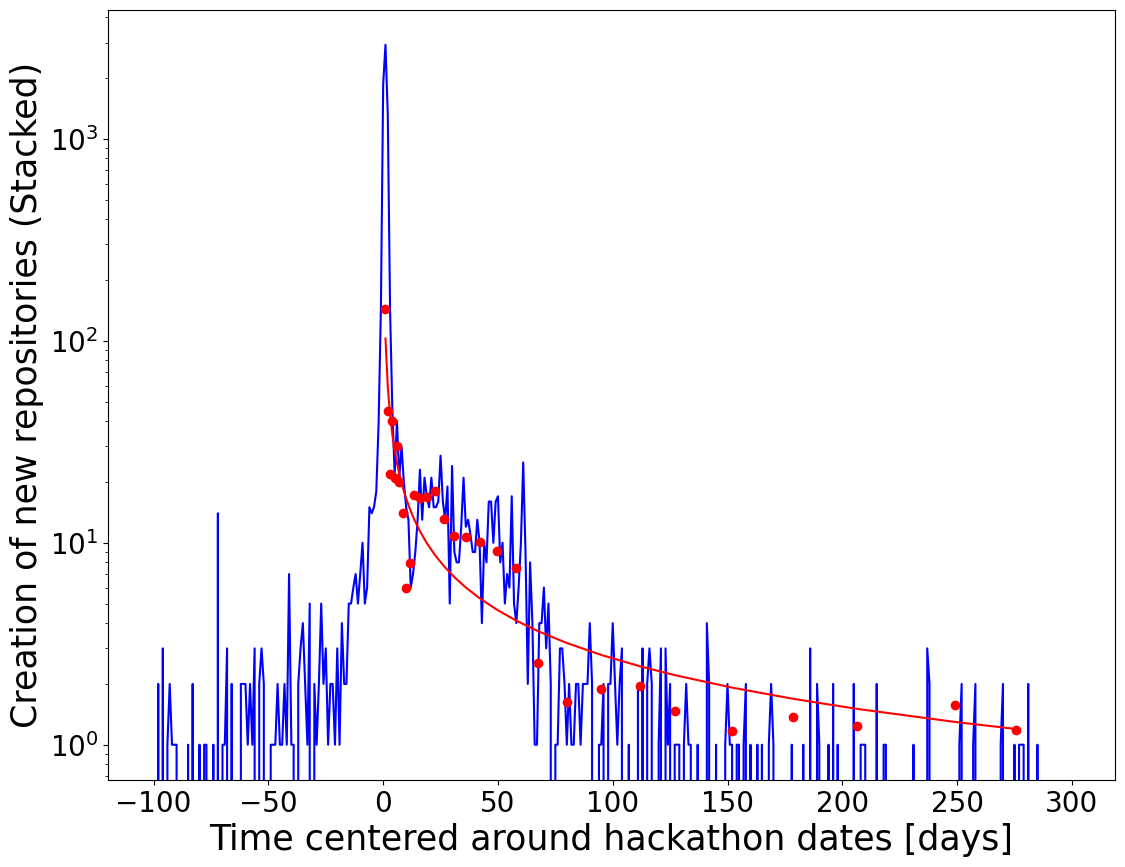

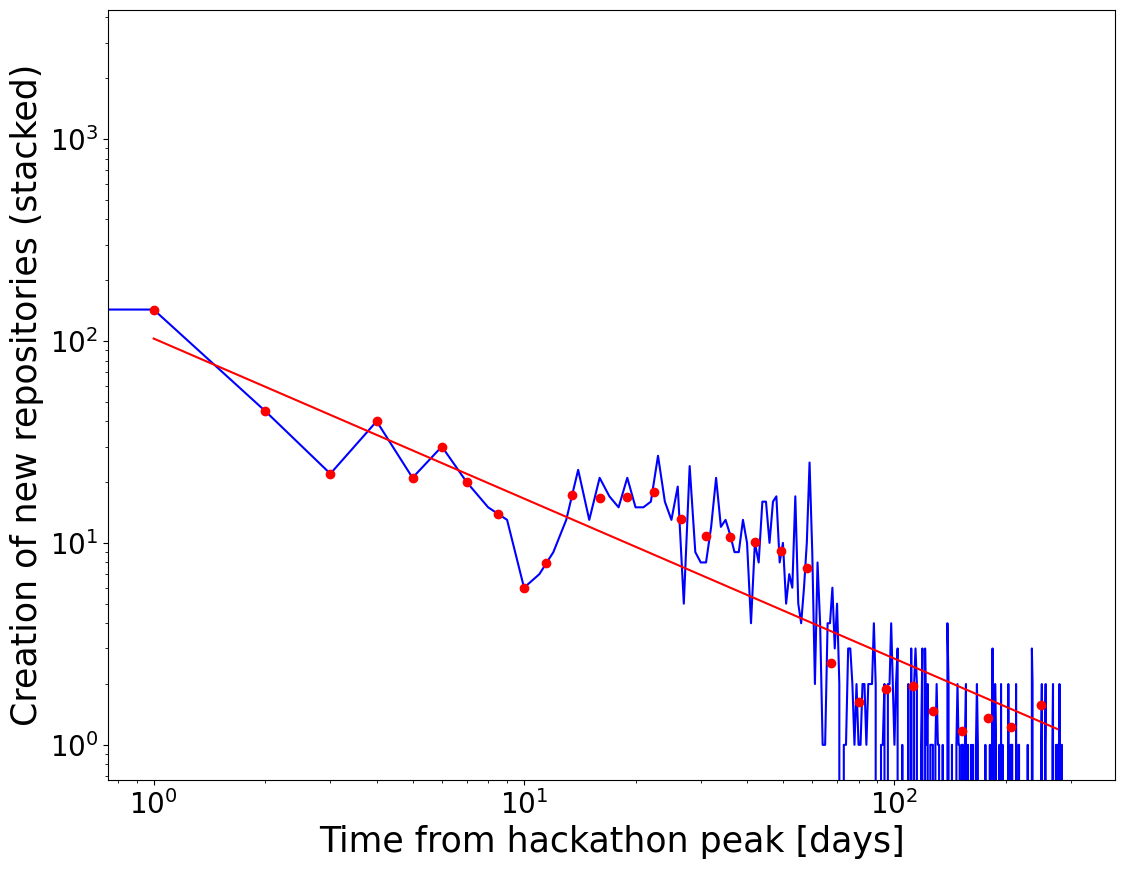

In [206]:
# Exogenous shocks and relaxations Repos creations

dic = dic_sdg
tc = 2

pl.figure(1,(13,10)) # Overall Repo Creation Dynamics
x = dic['vicinity_range']
y = dic['vicinity']


lx,ly = logify(dic['vicinity_range']-tc,dic['vicinity'])
B = binning(lx,ly,40)
x_cutoff = -1 #np.argwhere(B['mean'] < np.log10(1.7))[0][0]
#print(x_cutoff,B['bins'][:x_cutoff])

fitB = S.linregress(B['bins'][:x_cutoff],B['mean'][:x_cutoff])
print("fit B repoCreations: ", fitB)
fit = S.linregress(lx,ly)
print("fit repoCreations: ", fit)



#B = binning(x[c],ly,40)
#fitB = S.linregress(B['bins'][:x_cutoff],B['mean'][:x_cutoff])
#print(B['bins'])
pl.semilogy(x,y,'b-')
pl.semilogy(10**B['bins'],10**(B['mean']),'ro')
pl.semilogy(10**(B['bins']),10**(B['bins']*fitB[0]+fitB[1]),'r-')

#y0 = range(0,max(dic['vicinity']))
#pl.semilogy(np.zeros_like(y0),y0,'k-')
pl.xlabel("Time centered around hackathon dates [days]")
pl.ylabel("Creation of new repositories (Stacked)")
#pl.title("Creation of New Repositories Around Hackathons")
pl.savefig("output/figures/peak_repos_semilogy.eps")



pl.figure(2,(13,10)) #After Peak


pl.loglog(dic['vicinity_range']-tc,dic['vicinity'],'b-')
#pl.loglog(10**(lx),10**(lx*fit[0]+fit[1]),'k-')
pl.loglog(10**(B['bins'][:x_cutoff]),10**(B['mean'][:x_cutoff]),'ro')
pl.loglog(10**(B['bins']),10**(B['bins']*fitB[0]+fitB[1]),'r-')
pl.xlabel("Time from hackathon peak [days]")
pl.ylabel("Creation of new repositories (stacked)")
#pl.title("Creation of New Repositories Around Hackathons")
pl.savefig("output/figures/relaxation_repos_loglog.eps")

'''
pl.figure(3,(13,10)) # Before peak
x = dic['vicinity_range'] - 1 + 1.5
y = dic['vicinity'] 

c = (x < 0)*(x>-40)

lx,ly = logify(-x[c],y[c])
B = binning(lx,ly,20)
#x_cutoff = np.argwhere(B['mean'] < 2)[-1][0]


fitB = S.linregress(B['bins'][:x_cutoff],B['mean'][:x_cutoff])
print("fit B repoCreations: ", fitB)
fit = S.linregress(lx,ly)
print("fit repoCreations: ", fit)
pl.loglog(-x,y,'.')
pl.loglog(10**(B['bins']),10**(B['mean']),'rs')
pl.loglog(10**(B['bins']),10**(B['bins']*fitB[0]+fitB[1]),'r-')
'''

fit B sumEvents:  LinregressResult(slope=-0.8765153675966062, intercept=2.4808387581814646, rvalue=-0.9952020355784068, pvalue=1.0006516120148936e-24, stderr=0.017968271964386596, intercept_stderr=0.031362717290865705)
fit sumEvents:  LinregressResult(slope=-0.8313989069146059, intercept=2.399692821875985, rvalue=-0.788177642326052, pvalue=3.118417390632062e-148, stderr=0.024660958342648132, intercept_stderr=0.06036385902981895)


'\npl.figure(7)\ny = np.array(y)\ny_sum = np.array(y_sum)\n\nlx,ly = logify(y,y_sum)\n\nfit = S.linregress(lx,ly)\nprint("fit sumEvents vs countEvents: ",fit)\n\nB = binning(lx,ly,30)\nfitB = S.linregress(B[\'bins\'],B[\'mean\'])\nprint("fit B sumEvents vs countEvents: ", fitB)\n\npl.loglog(y,y_sum,\'.\')\npl.loglog(10**lx,10**(lx*fit[0] + fit[1]),\'k-\')\npl.loglog(10**(B[\'bins\']),10**(B[\'mean\']),\'ro\')\npl.loglog(10**(lx),10**(lx*fitB[0]+fitB[1]),\'r-\')\npl.xlabel("Activity")\npl.ylabel("Sum Events")\n'

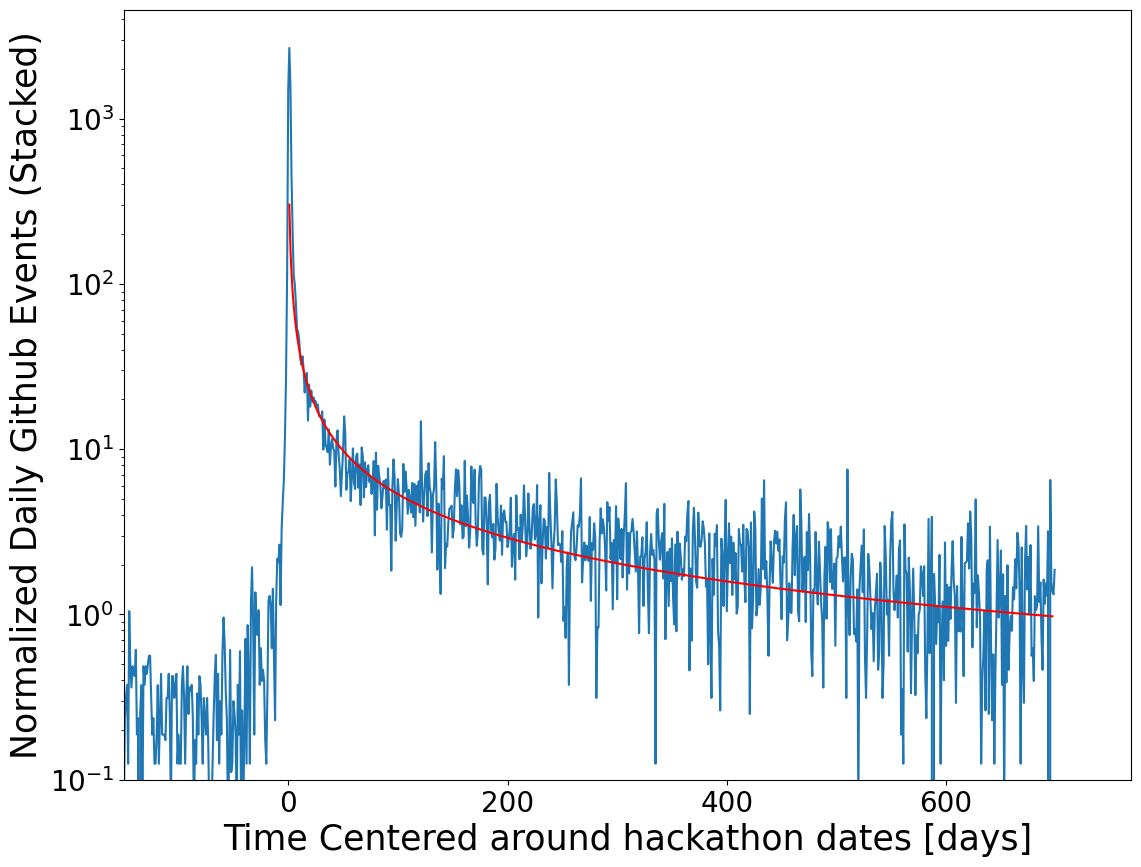

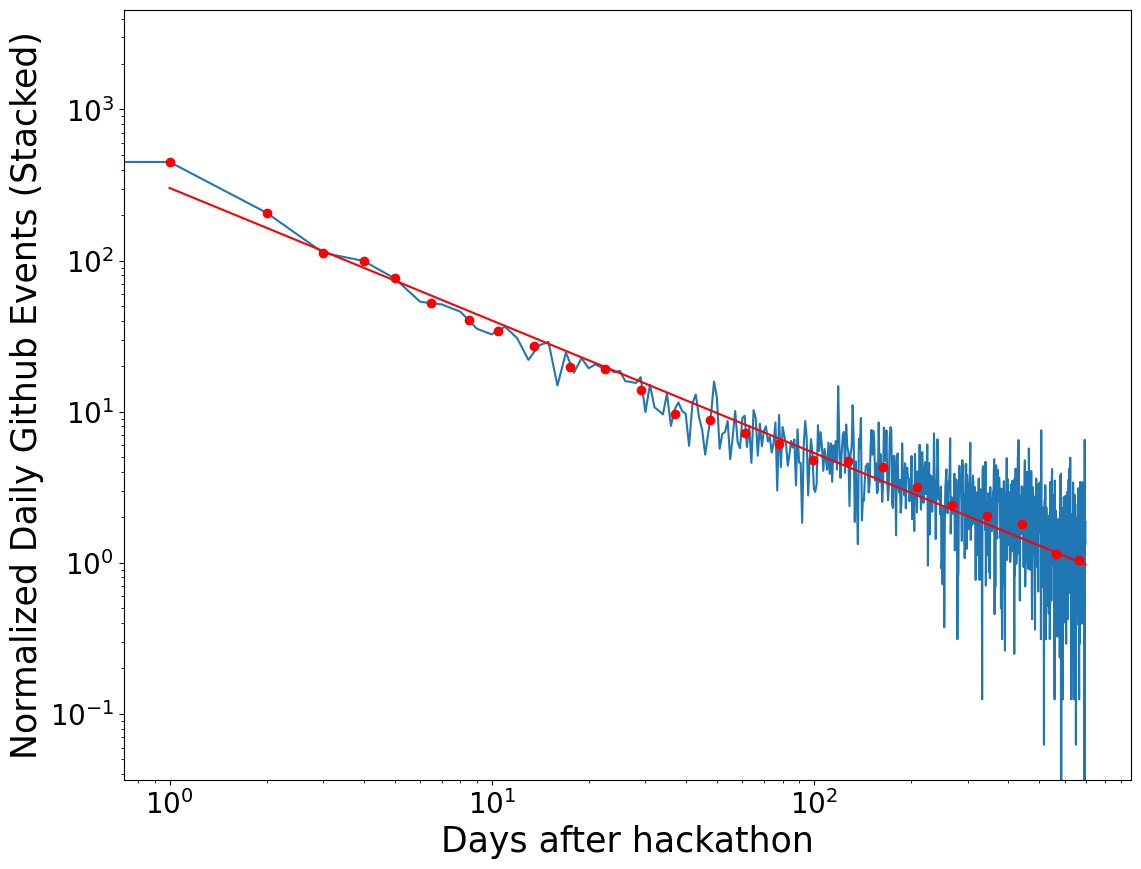

In [144]:
# Exogenous shocks and relaxations Github activity 
dic = dic_sdg

years = 3
x = np.arange(-365*years,365*years)
tc = 2
y = []
y_sum = []
#legend_fig1 = []

dip_events_t = []
dip_events_y = []


for dt in x:
    cond = dic['Delta_Days'] == dt
    y.append(len(dic['Count_Events_Normalized'][cond]))
    y_sum.append(np.sum(dic['Count_Events_Normalized'][cond]))

    if dt > -700 and dt < 700 and dt%1 == 0:
        #legend_fig1.append(dt)
        count_x,count_y = rankorder(dic['Count_Events_Normalized'][cond])
        #pl.semilogy(count_x,count_y/np.sum(count_y),'-')
        #pl.xlabel("number of events per day")
        #pl.ylabel("rank-ordering")
        dip_events_t.append(dt)
        dip_events_y.append(np.sum(count_x))
        #print(dt,np.mean(count_x/len(count_x)))


y = np.array(y)#/np.sum(y)
y_sum = np.array(y_sum)

#pl.figure(1,(13,10))
#lx,ly =logify(y,y_sum)
#B = binning(lx,ly,30)
#fitB = S.linregress(B['bins'],B['mean'])
#print(fitB)

#pl.loglog(y,y_sum,'o')
#pl.loglog(10**(B['bins']),10**(B['mean']),'ro')
#pl.loglog(10**(lx),10**(lx*fitB[0]+fitB[1]),'r-')
#pl.xlabel("Active Days ")
#pl.ylabel("Number of Events")


'''
pl.figure(4,(13,10)) # Activity

t = x-tc
cond = t > 0

lx,ly = logify(t[cond],y[cond])
B = binning(lx,ly,30)


fitB = S.linregress(B['bins'],B['mean'])
print(fitB)
fit = S.linregress(lx,ly)
print(fit)

pl.semilogy(t,y,'-')
pl.xlabel("Time Centered around hackathon dates [days]")
pl.ylabel("Normalized Average Daily Activity (Stacked)")
#pl.title("Days of Activity Around Hackathons")



pl.figure(2,(13,10)) # Decay Activity

pl.loglog(t,y)
pl.loglog(10**(lx),10**(lx*fit[0]+fit[1]),'k-')
pl.loglog(10**(B['bins']),10**(B['mean']),'ro')
pl.loglog(10**(lx),10**(lx*fitB[0]+fitB[1]),'r-')
pl.xlabel("Days after hackathon")
pl.ylabel("Normalized Average Daily Activity (Stacked)")


pl.figure(3,(13,10))

cond = t - tc < 0 
pl.loglog(-t[cond],y[cond])

lx,ly = logify(-t[cond],y[cond])
fit = S.linregress(lx,ly)
print(fit)
pl.loglog(10**(lx),10**(lx*fit[0]+fit[1]),'r-')
'''

dip_events_t = np.array(dip_events_t)
dip_events_y = np.array(dip_events_y)#/np.sum(dip_events_y)


t = dip_events_t - tc
cond = t > 0

lx,ly = logify(t[cond],dip_events_y[cond])
B = binning(lx,ly,30)

fitB = S.linregress(B['bins'],B['mean'])
print("fit B sumEvents: ", fitB)
fit = S.linregress(lx,ly)
print("fit sumEvents: ", fit)



pl.figure(6,(13,10)) # Count Events
pl.semilogy(dip_events_t,dip_events_y)
#pl.semilogy(10**(B['bins']),10**(B['mean']),'ro')
pl.semilogy(10**(lx),10**(lx*fitB[0]+fitB[1]),'r-')
pl.xlabel("Time Centered around hackathon dates [days]")
pl.ylabel("Normalized Daily Github Events (Stacked)")
#pl.title("Github Events around hackathons")
pl.xlim(xmin=-150)
pl.ylim(ymin = 0.1)
pl.savefig("output/figures/peak_events_semilogy.eps")


pl.figure(5,(13,10)) # Decay Count Events
pl.loglog(np.array(dip_events_t) - tc,dip_events_y,'-')
#pl.loglog(10**(lx),10**(lx*fit[0]+fit[1]),'k-')
pl.loglog(10**(B['bins']),10**(B['mean']),'ro')
pl.loglog(10**(lx),10**(lx*fitB[0]+fitB[1]),'r-')
pl.xlabel("Days after hackathon")
pl.ylabel("Normalized Daily Github Events (Stacked)")
pl.savefig("output/figures/relaxation_events_loglog.eps")



'''
pl.figure(7)
y = np.array(y)
y_sum = np.array(y_sum)

lx,ly = logify(y,y_sum)

fit = S.linregress(lx,ly)
print("fit sumEvents vs countEvents: ",fit)

B = binning(lx,ly,30)
fitB = S.linregress(B['bins'],B['mean'])
print("fit B sumEvents vs countEvents: ", fitB)

pl.loglog(y,y_sum,'.')
pl.loglog(10**lx,10**(lx*fit[0] + fit[1]),'k-')
pl.loglog(10**(B['bins']),10**(B['mean']),'ro')
pl.loglog(10**(lx),10**(lx*fitB[0]+fitB[1]),'r-')
pl.xlabel("Activity")
pl.ylabel("Sum Events")
'''


2.711302513125005 3.3422402564276306
0.0003179412369784361
Re-setting some zeros.
LinregressResult(slope=-2.60918999451939, intercept=-1.6965930518281995, rvalue=-0.995844896428313, pvalue=0.0, stderr=0.0076967366903536415, intercept_stderr=0.013399707023751616)


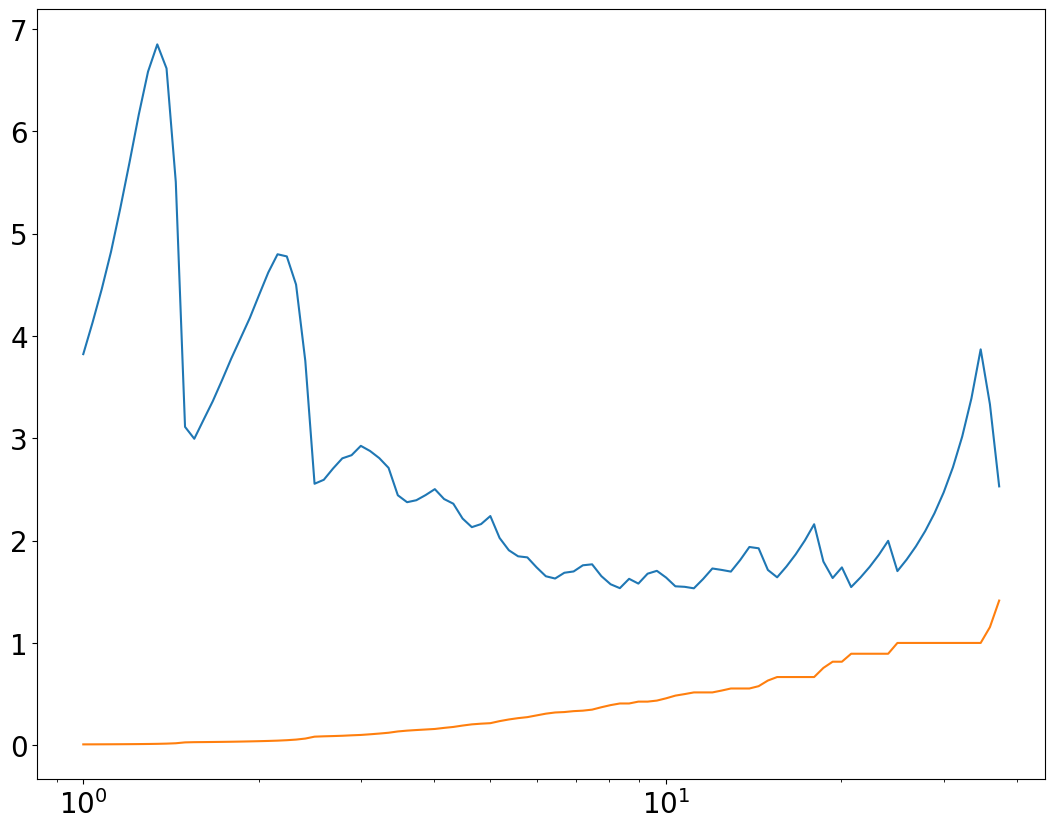

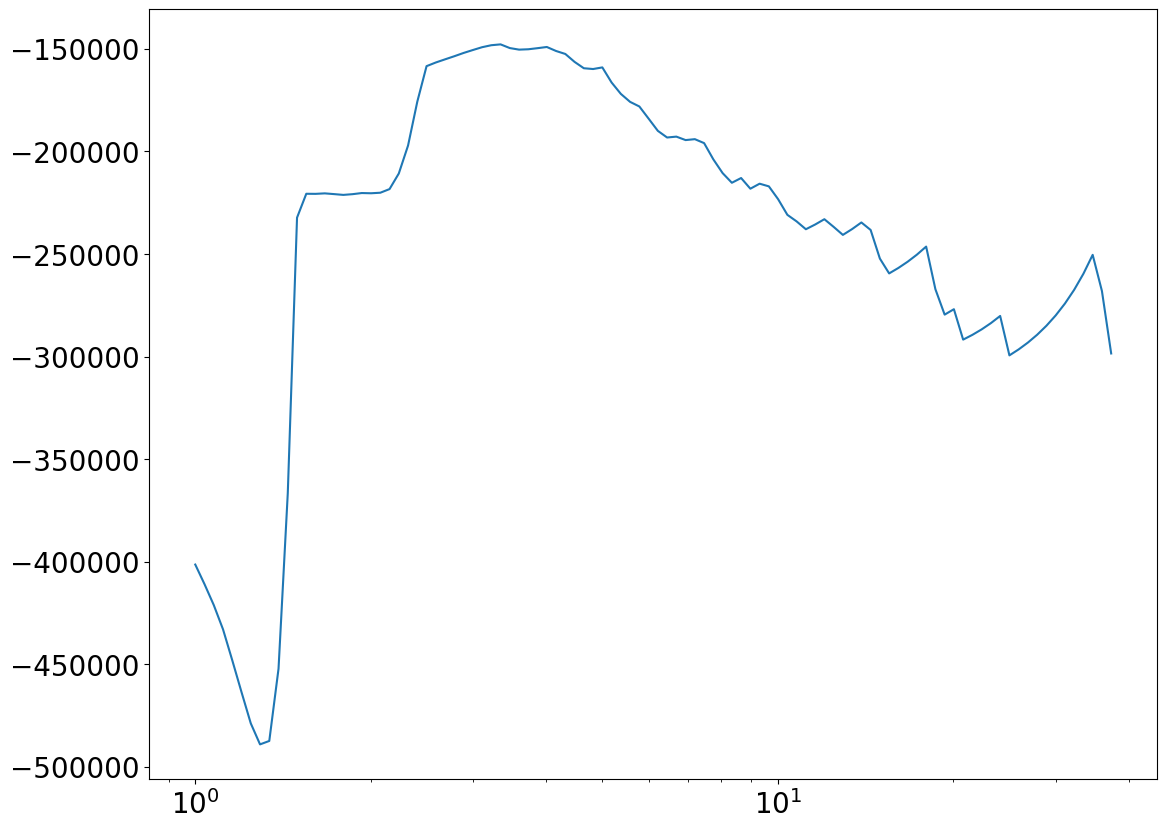

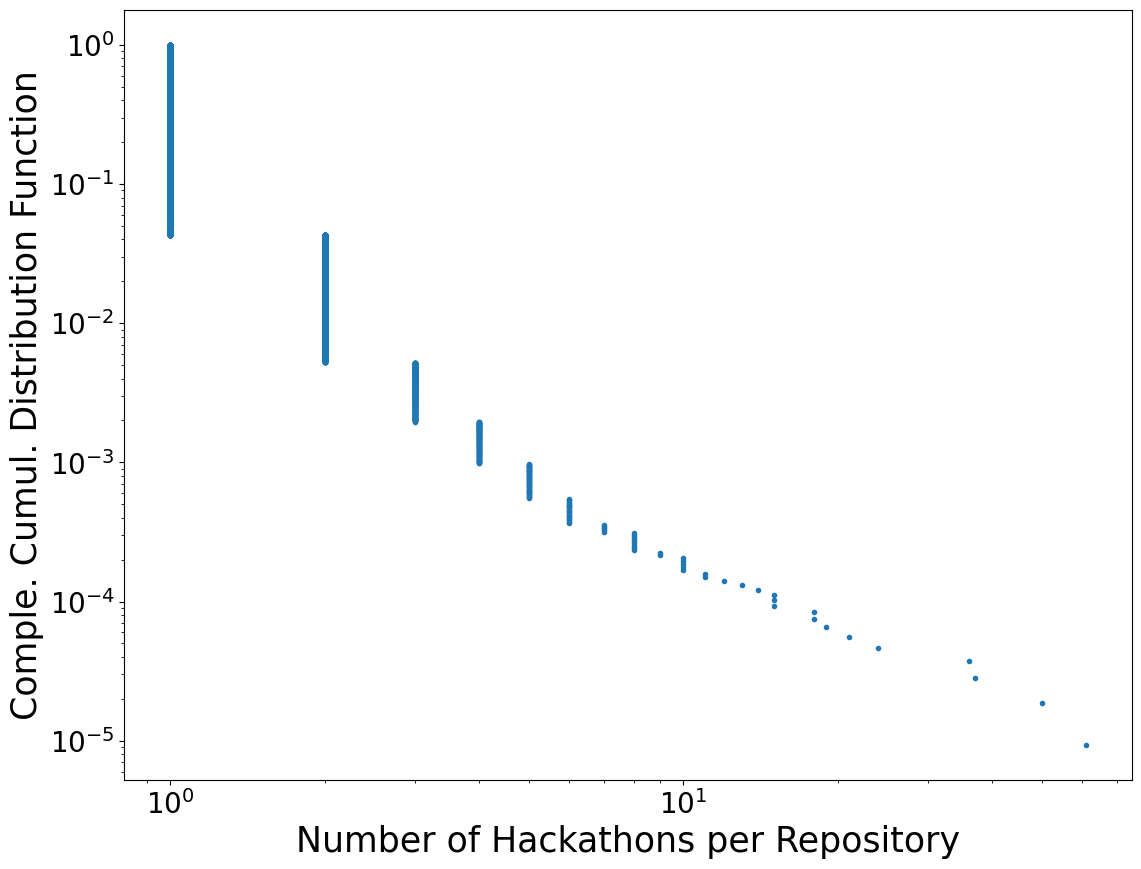

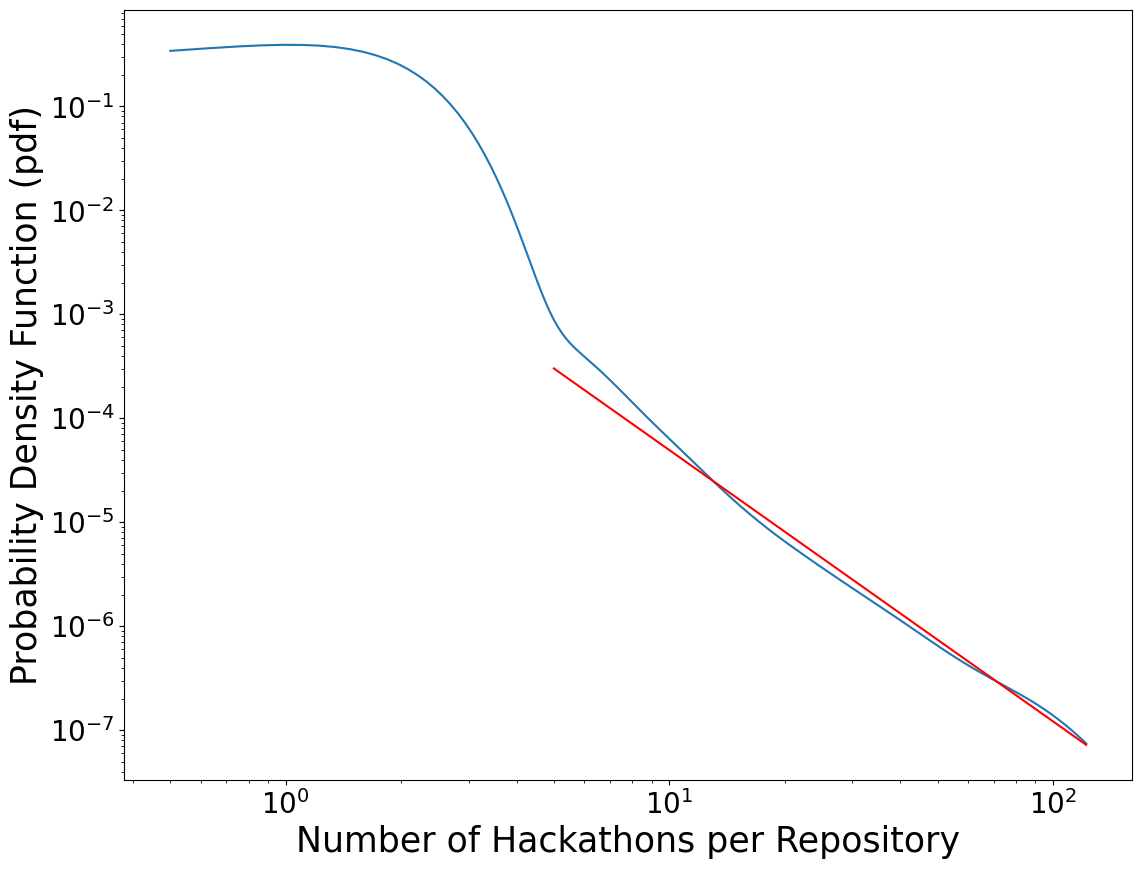

In [390]:
# Distribution of Hackathons per Repository

data = dicDF['df_hack_repos_sdg'].groupby(["repoID"]).count()['projectID'].values
x,y = rankorder(data)
data_rand = data + (np.random.rand(len(data)) - 0.5)

index,mu,error,llh,points = vary_threshold(data_rand,xmin=1,index=100,type='cont')
#print(index,mu,error,llh,points)

pl.figure(3,(13,10))
pl.semilogx(index,mu)
pl.semilogx(index,error)
pl.figure(4,(13,10))
pl.semilogx(index,llh)

i_max_llh = np.argmax(llh)
print(mu[i_max_llh],index[i_max_llh])


pl.figure(1,(13,10))
y_norm = y/y[-1]

y_norm_min = y_norm[i_max_llh]
print(y_norm_min)

pl.loglog(x,y_norm,'.')

#mu= 2
#xFit = np.logspace(np.log10(index[i_max_llh]),np.log10(max(x)))
#yFit = y_norm_min*1/(xFit/float(index[i_max_llh]))**mu
#pl.loglog(xFit,yFit,'k:')

pl.xlabel("Number of Hackathons per Repository")
pl.ylabel("Comple. Cumul. Distribution Function")
pl.savefig("output/figures/hack_per_repo.eps")



pl.figure(2,(13,10))
x,y = adaptive_kernel_quantile_pdf_tom(data)
cond = y < 5*10**-4
cond = y < 10**-3

lx,ly = logify(x,y)
fit = S.linregress(lx[cond],ly[cond])
print(fit)

pl.loglog(x,y,'-')
pl.loglog(10**lx[cond],10**(lx[cond]*fit[0]+fit[1]),'r-')
pl.xlabel("Number of Hackathons per Repository")
pl.ylabel("Probability Density Function (pdf)")
pl.savefig("output/figures/hack_per_repo_ak.eps")



#### Here we ask how many new users and how many returning users for each hackathon

In [359]:
t_week[116-52]

Timestamp('2011-01-02 00:00:00')

In [360]:
timestamp_20120101 = tseries_hacks.index[116]
timestamp_20110102 = t_week[116-52]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0 hack
[64]
665
LinregressResult(slope=0.03273043403037061, intercept=-2.669511616880035, rvalue=0.7152283861129332, pvalue=3.0153417986800822e-105, stderr=0.0012421086428423436, intercept_stderr=0.47635473738234596)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1 projects
[11]
612
LinregressResult(slope=0.9222687486391913, intercept=-97.39852754587423, rvalue=0.6396801449095609, pvalue=9.852623313317682e-72, stderr=0.0448697211276723, intercept_stderr=15.83476340618023)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2 participants
[64]
665
LinregressResult(slope=2.879817542880321, intercept=-258.1701009279959, rvalue=0.5693035994047921, pvalue=2.1824877995869466e-58, stderr=0.16151147587970635, intercept_stderr=61.94044065328827)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


'\npl.figure(4,(21,5))\n\nprint(fit)\npl.bar(x,y,width=1)\npl.plot(x,x*fit[0]+fit[1],\'r--\')\npl.xlabel("years")\npl.ylabel("hackathons per week")\n\npl.figure(5,(21,5))\n\npl.bar(x,y_detrend,width=1)\n\n\npl.figure(6,(21,5))\npl.bar(t_week,y_detrend,width=7)\n\n'

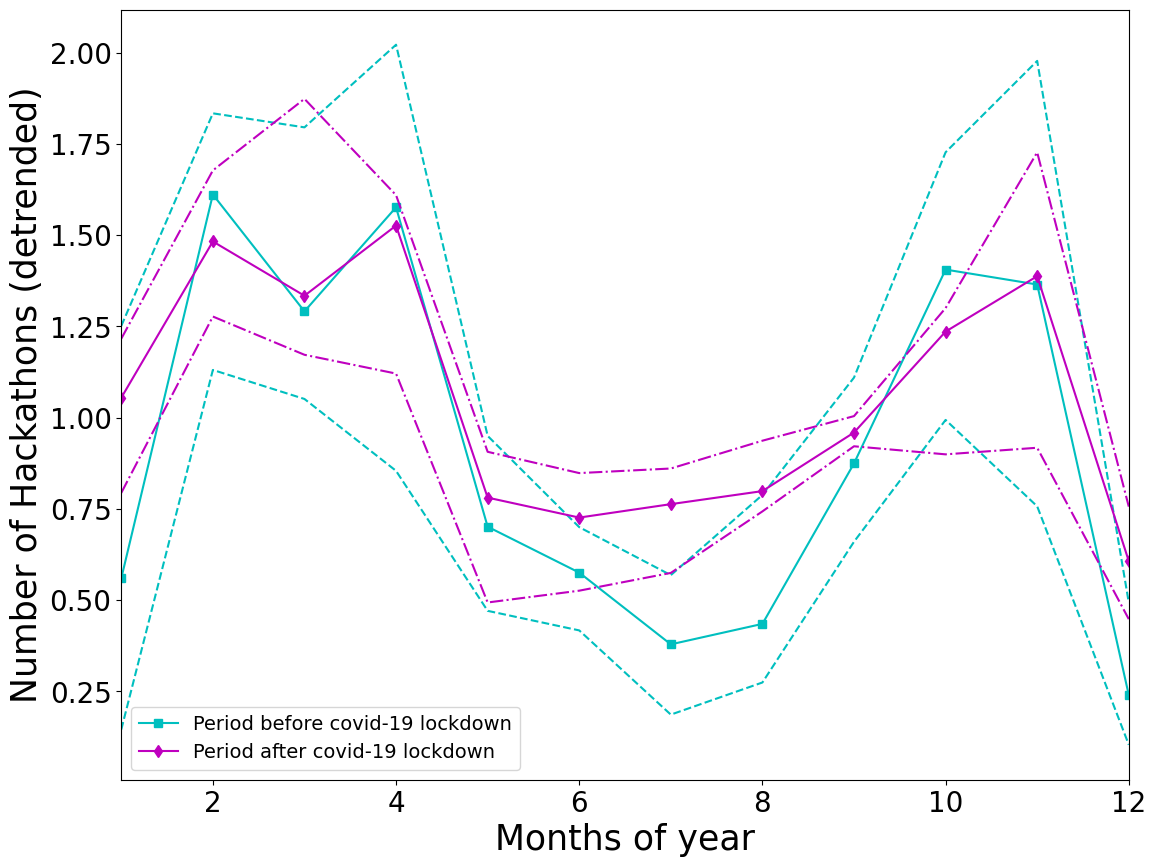

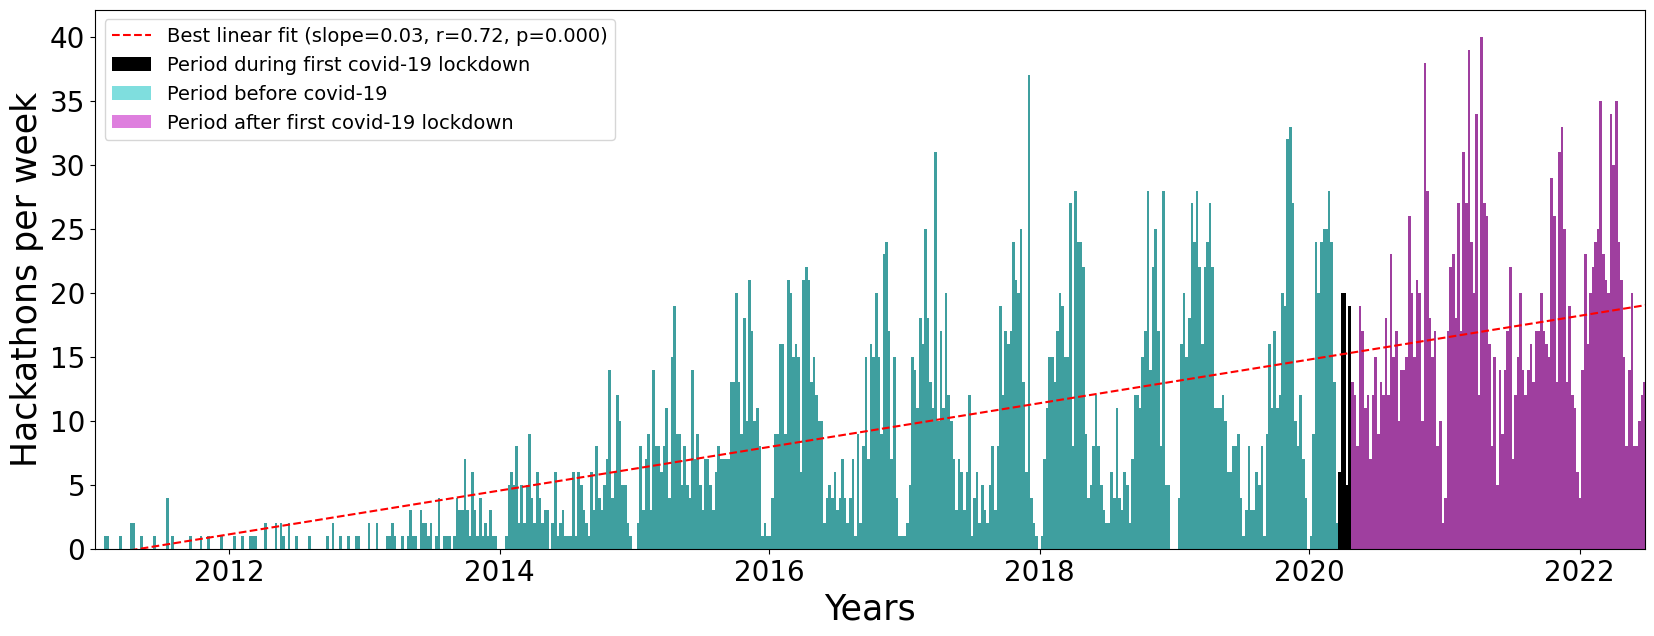

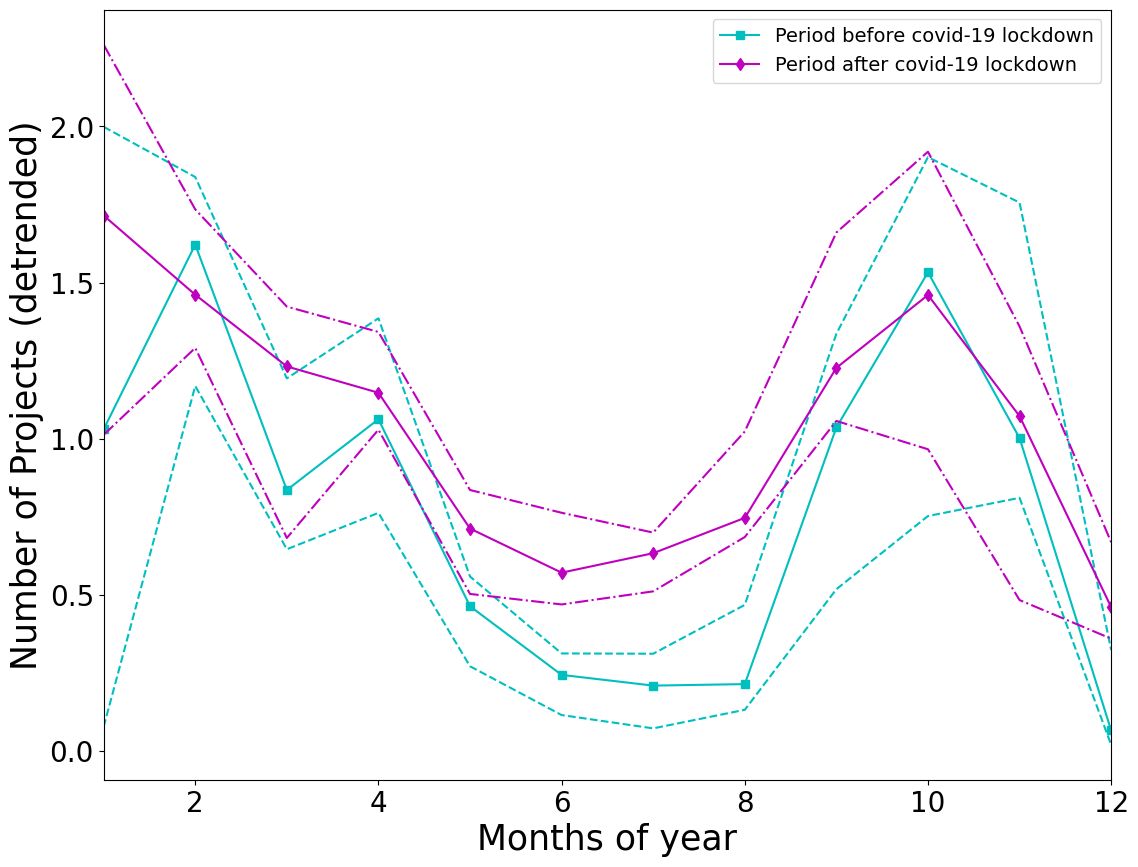

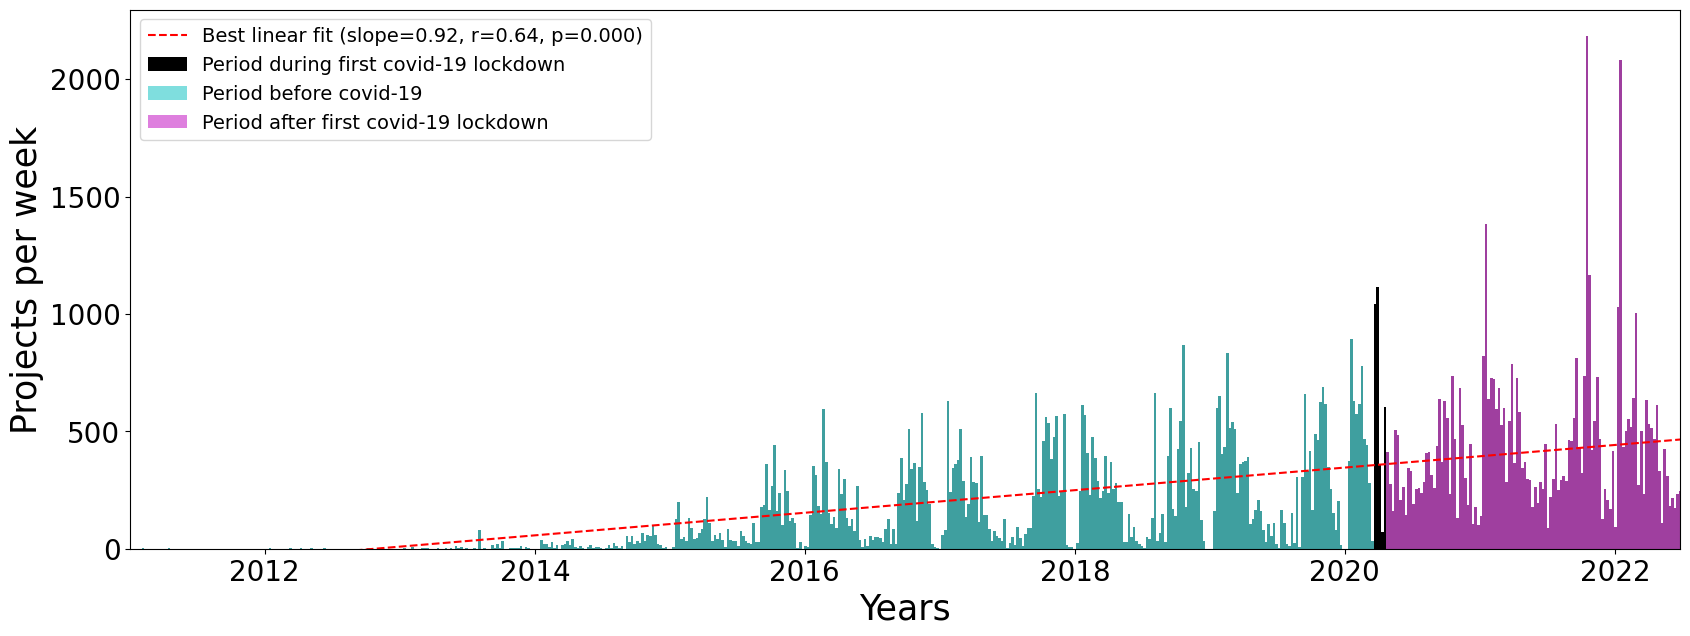

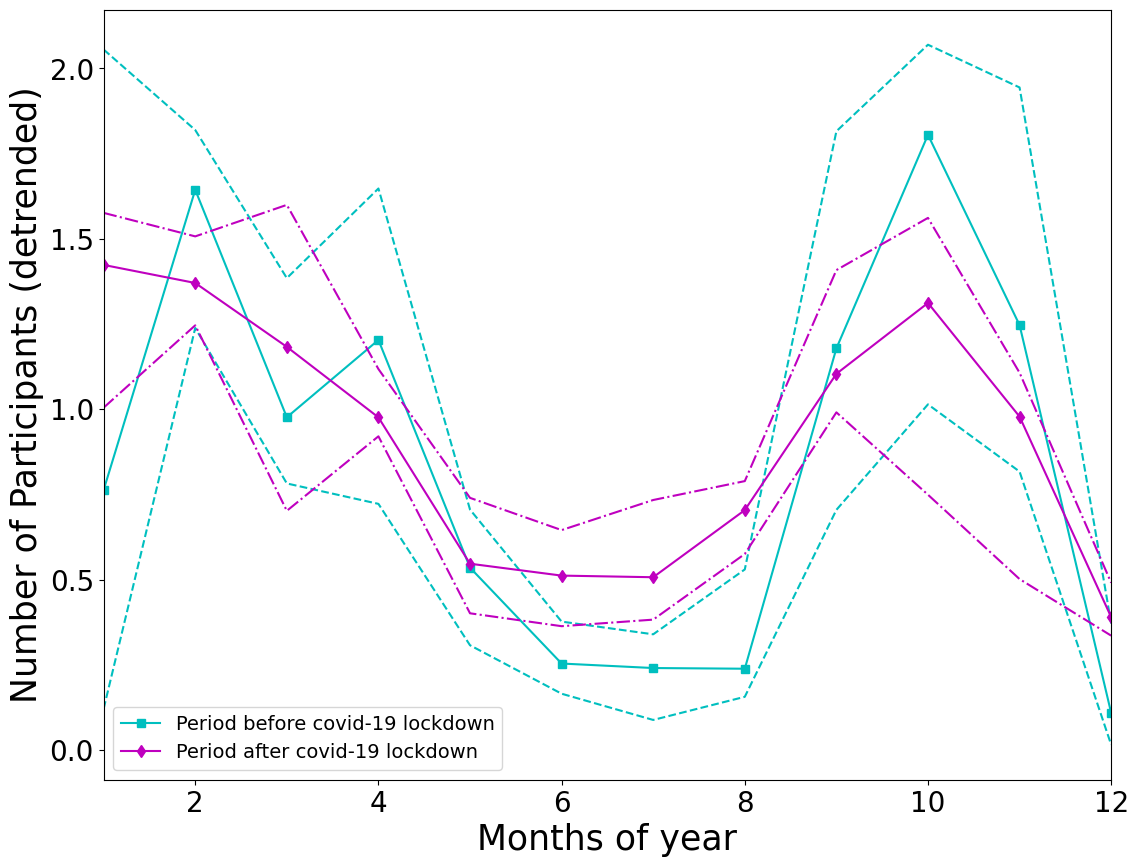

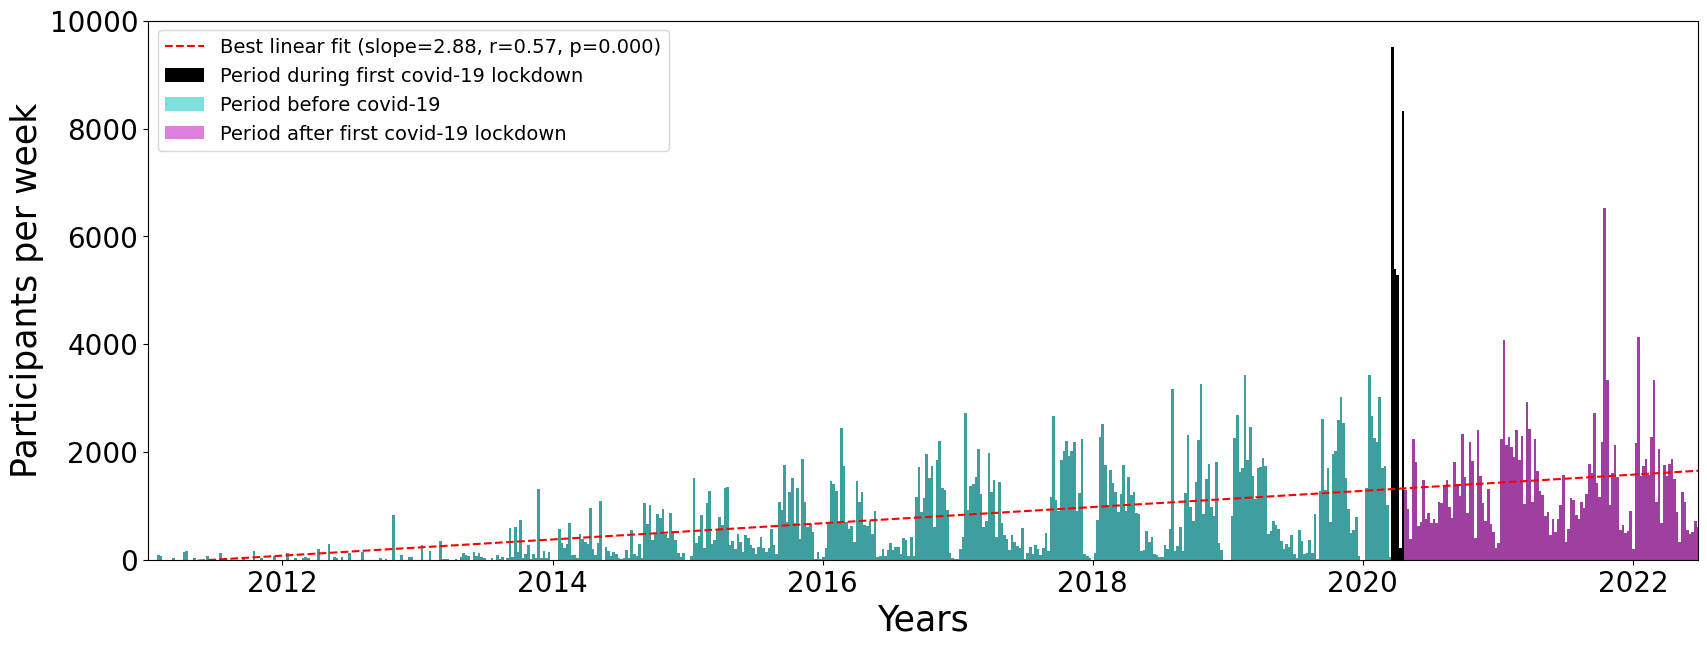

In [365]:
# Time Series + Monthly periodicity (weekly bins)

# Projects
df_hack_repos = dicDF["df_hack_repos_sdg"]
df_hack_repos['datetimeindex'] = pd.DatetimeIndex(df_hack_repos['timestamp'])
#tseries_hacks = df_hack_repos.groupby(pd.Grouper(key='datetimeindex', freq='W')).size()

# Participants
df_hack_participants = dicDF["df_hack_participants_sdg"]
df_hack_participants['datetimeindex'] = pd.DatetimeIndex(df_hack_participants['timestamp'])
tseries_hacks = df_hack_participants.groupby(pd.Grouper(key='datetimeindex', freq='W')).size()

# Hackathons
df_hack_time = dicDF["df_hack_time_sdg"]

#tseries_hacks = df_hack_time.groupby(pd.Grouper(key='datetimeindex', freq='W')).size()

dic = {'hack': {'df' : df_hack_time, 'label': "Hackathons",'t_start_covid19':545},
       'projects' :{'df' : df_hack_repos, 'label': "Projects",'t_start_covid19':545-53}, 
       'participants' : {'df' : df_hack_participants, 'label': "Participants",'t_start_covid19':545}
       }

pl.close()

for k,key in enumerate(dic.keys()):
    print(k,key)
    #if key=="participants": continue
    
    tseries_hacks = dic[key]['df'].groupby(pd.Grouper(key='datetimeindex', freq='W')).size()

    t_week = tseries_hacks.index

    index_2012 = np.argwhere(t_week==timestamp_20110102)[0]
    print(index_2012)
    print(len(t_week))
    hacks_per_week = tseries_hacks.values


    x = np.arange(0,len(t_week))
    y = hacks_per_week

    fit = S.linregress(x,y)
    print(fit)
    y_fit = x*fit[0]+fit[1]
    y_detrend = y/y_fit

    c0 = x > 200

    c_before_covid = x < dic[key]['t_start_covid19']
    c_after_covid = x > dic[key]['t_start_covid19'] + 4
    c_during_covid =  (x >= dic[key]['t_start_covid19'] )*( x <= dic[key]['t_start_covid19'] + 4)

    pl.figure(k+1,(13,10))
    months = t_week.month.values

    B = binning(months[c0*c_before_covid], y_detrend[c0*c_before_covid],np.arange(1,14),confinter=25)
    #pl.bar(B['bins'],B['median'],width=1,alpha=0.5,color="c",label="Period before covid-19 lockdown")
    pl.plot(B['bins'],B['median'],'c-s',label="Period before covid-19 lockdown")
    pl.plot(B['bins'],B['percUp'],'c--',ms = 4)
    pl.plot(B['bins'],B['percDown'],'c--',ms = 4)

    B = binning(months[c0*c_after_covid], y_detrend[c0*c_after_covid],np.arange(1,14),confinter=25)
    #pl.bar(B['bins'],B['median'],width=1,alpha=0.5, color="m",label="Period after covid-19 lockdown")
    pl.plot(B['bins'],B['median'],'m-d',label="Period after covid-19 lockdown")
    pl.plot(B['bins'],B['percUp'],'m-.',ms = 4)
    pl.plot(B['bins'],B['percDown'],'m-.',ms = 4)

    pl.legend(loc=0)

    pl.xlabel("Months of year")
    pl.ylabel("Number of %s (detrended)"%dic[key]['label'])
    pl.xlim(xmin=1,xmax=12)
    pl.savefig("output/figures/detrended_seasonality_%s.eps"%dic[key]['label'])


    pl.figure(k+4,(20,7))
    pl.bar(t_week,hacks_per_week,width=7,color='k',alpha=0.5)
    pl.bar(t_week[c_during_covid],hacks_per_week[c_during_covid],width=7,color='k',alpha=1, label="Period during first covid-19 lockdown")
    pl.bar(t_week[c_before_covid],hacks_per_week[c_before_covid],width=7,color='c',alpha=0.5,label="Period before covid-19")
    pl.bar(t_week[c_after_covid],hacks_per_week[c_after_covid],width=7,color='m',alpha=0.5, label="Period after first covid-19 lockdown")

    #pl.plot(x.index,x.values)
    pl.plot(t_week,x*fit[0]+fit[1],'r--',label="Best linear fit (slope=%.2f, r=%.2f, p=%.3f)"%(fit[0],fit[2],fit[3]))
    pl.xlim(xmin=t_week[index_2012],xmax=t_week[-2])
    pl.ylim(ymin=0)
    pl.legend(loc=0)
    pl.xlabel("Years")
    pl.ylabel("%s per week"%dic[key]['label'])

    pl.savefig("output/figures/time_series_%s.eps"%dic[key]['label'])

'''
pl.figure(4,(21,5))

print(fit)
pl.bar(x,y,width=1)
pl.plot(x,x*fit[0]+fit[1],'r--')
pl.xlabel("years")
pl.ylabel("hackathons per week")

pl.figure(5,(21,5))

pl.bar(x,y_detrend,width=1)


pl.figure(6,(21,5))
pl.bar(t_week,y_detrend,width=7)

'''


/var/folders/yc/fc0cc5d901x35k14h_yys6wr0000gt/T/ipykernel_42623/1647485548.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tseries_hacks = dic[key]['df'].groupby(pd.Grouper(key='datetimeindex', freq='M')).size()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0 hack
154
LinregressResult(slope=0.5997699959749295, intercept=-10.486300795978217, rvalue=0.7895650345750695, pvalue=4.75333260985555e-34, stderr=0.037810091533133576, intercept_stderr=3.3453919435131105)


/var/folders/yc/fc0cc5d901x35k14h_yys6wr0000gt/T/ipykernel_42623/1647485548.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tseries_hacks = dic[key]['df'].groupby(pd.Grouper(key='datetimeindex', freq='M')).size()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1 projects
142
LinregressResult(slope=16.852143062211987, intercept=-393.5338323648183, rvalue=0.745842725973574, pvalue=1.7806675522256495e-26, stderr=1.272030989266626, intercept_stderr=103.73488758282876)


/var/folders/yc/fc0cc5d901x35k14h_yys6wr0000gt/T/ipykernel_42623/1647485548.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tseries_hacks = dic[key]['df'].groupby(pd.Grouper(key='datetimeindex', freq='M')).size()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2 participants
154
LinregressResult(slope=52.7814896046395, intercept=-1023.9982404692078, rvalue=0.7052743572300203, pvalue=1.783475435776266e-24, stderr=4.303361671990888, intercept_stderr=380.7563241386392)


'\npl.figure(4,(21,5))\n\nprint(fit)\npl.bar(x,y,width=1)\npl.plot(x,x*fit[0]+fit[1],\'r--\')\npl.xlabel("years")\npl.ylabel("hackathons per week")\n\npl.figure(5,(21,5))\n\npl.bar(x,y_detrend,width=1)\n\n\npl.figure(6,(21,5))\npl.bar(t_week,y_detrend,width=7)\n\n'

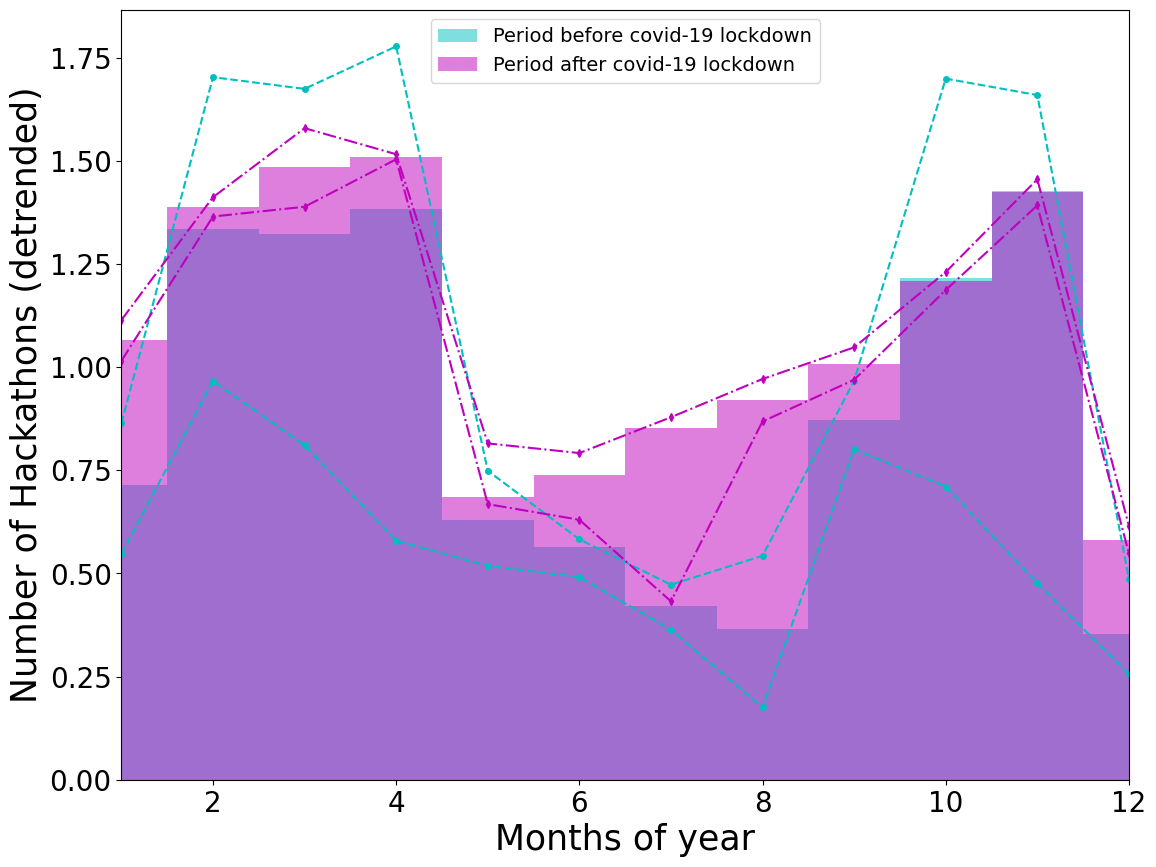

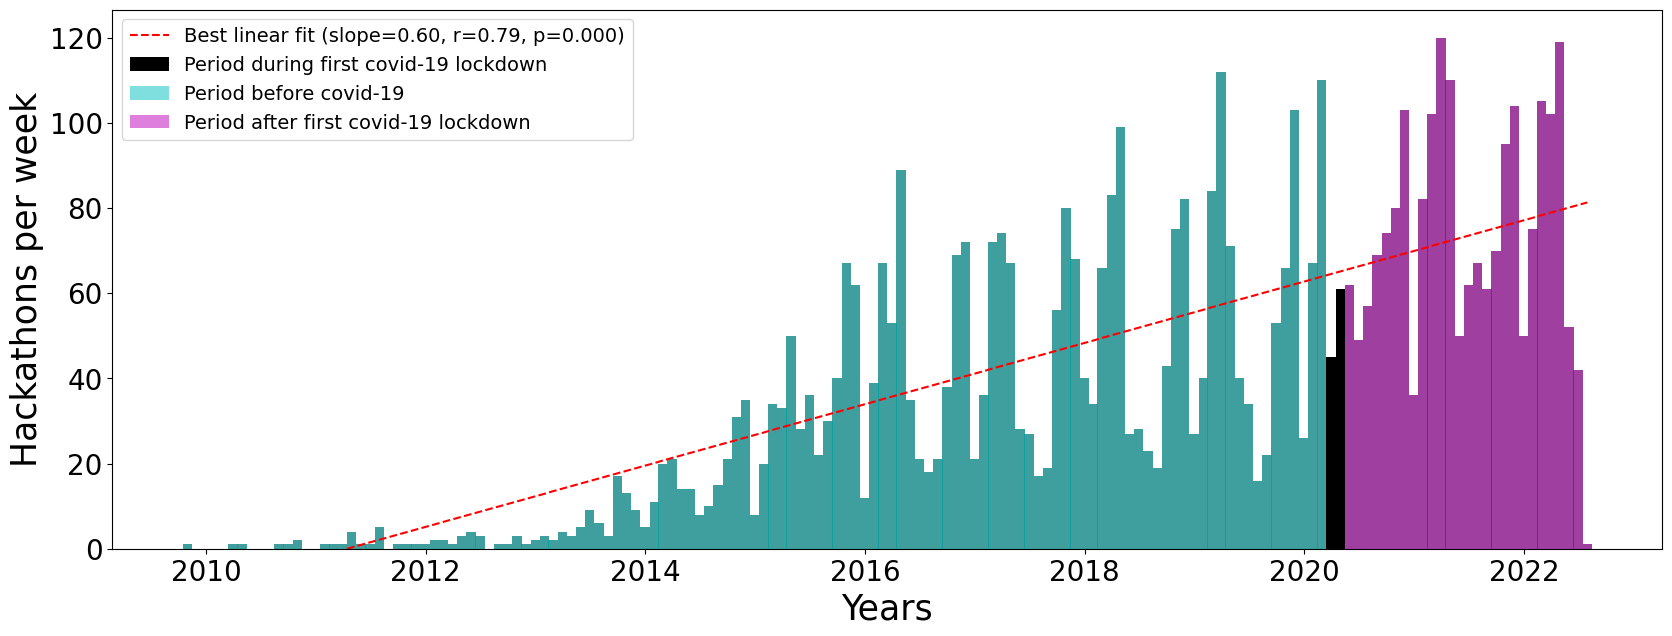

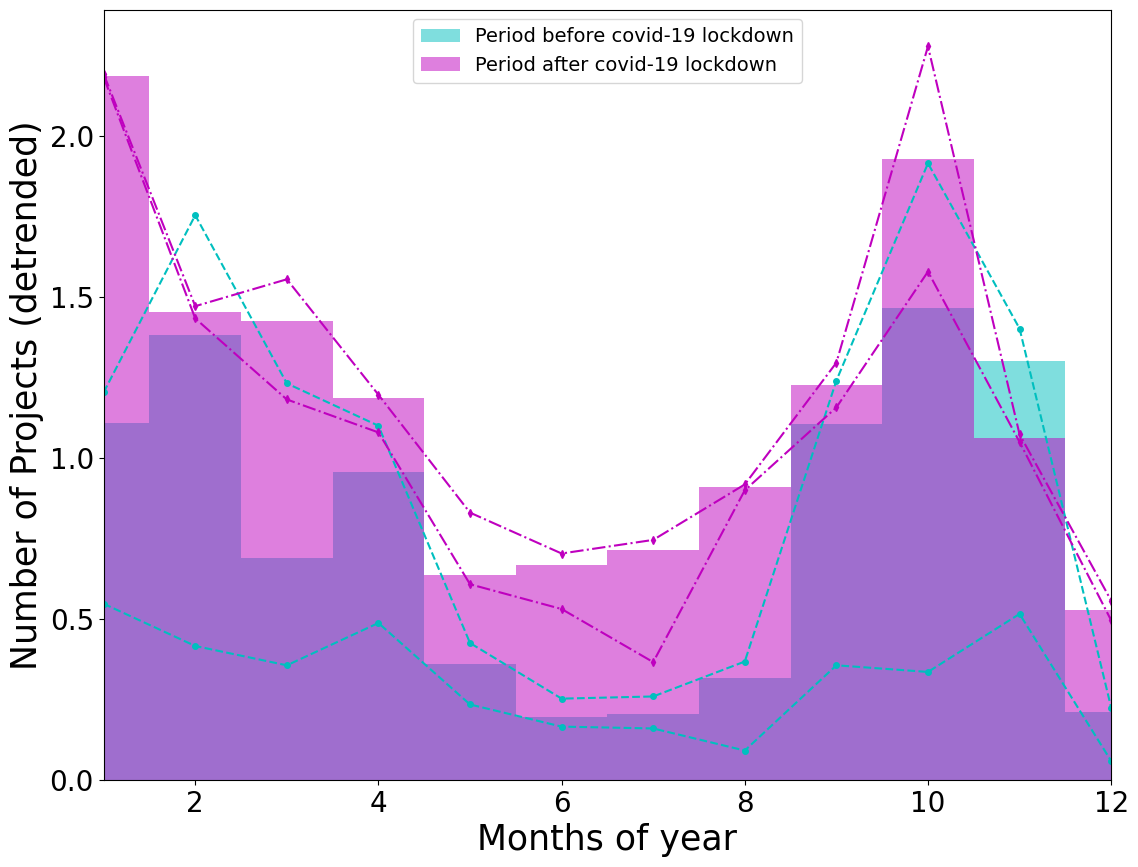

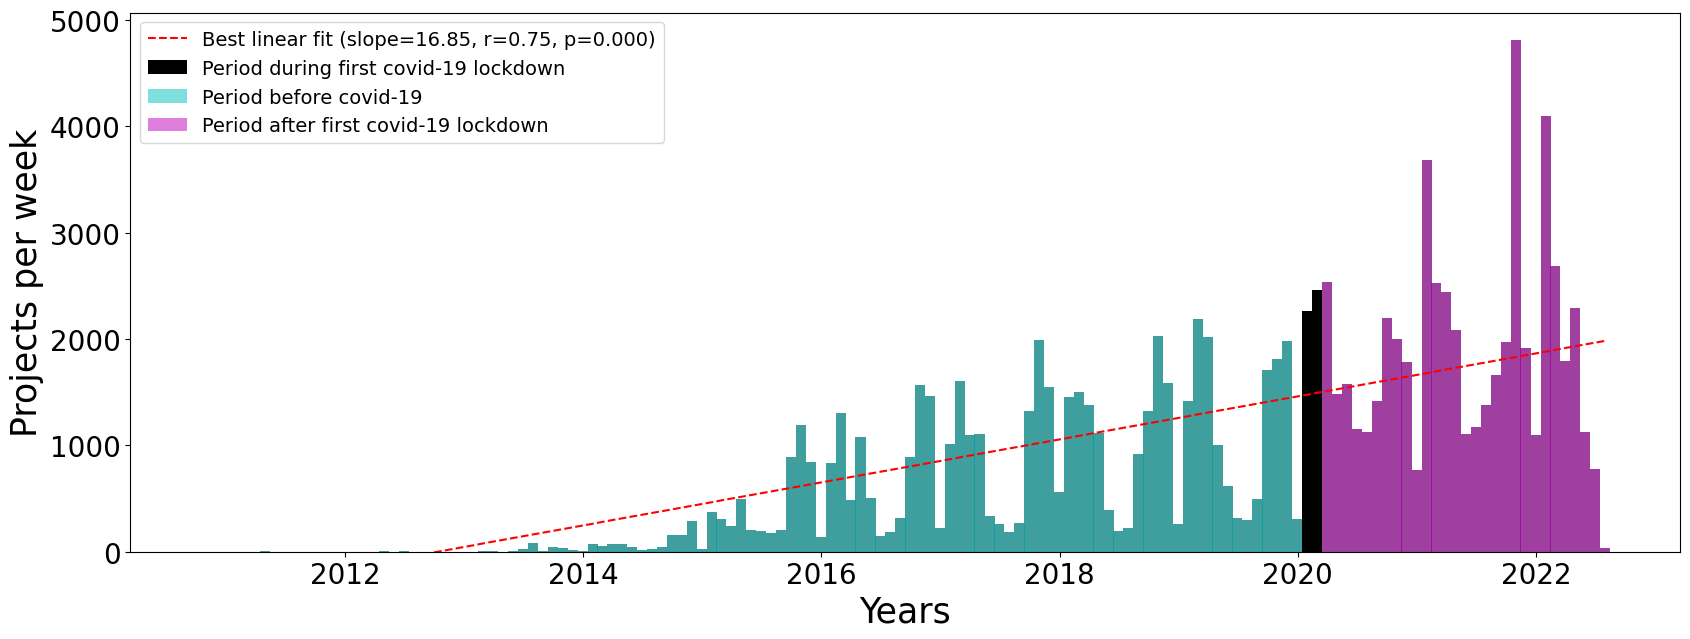

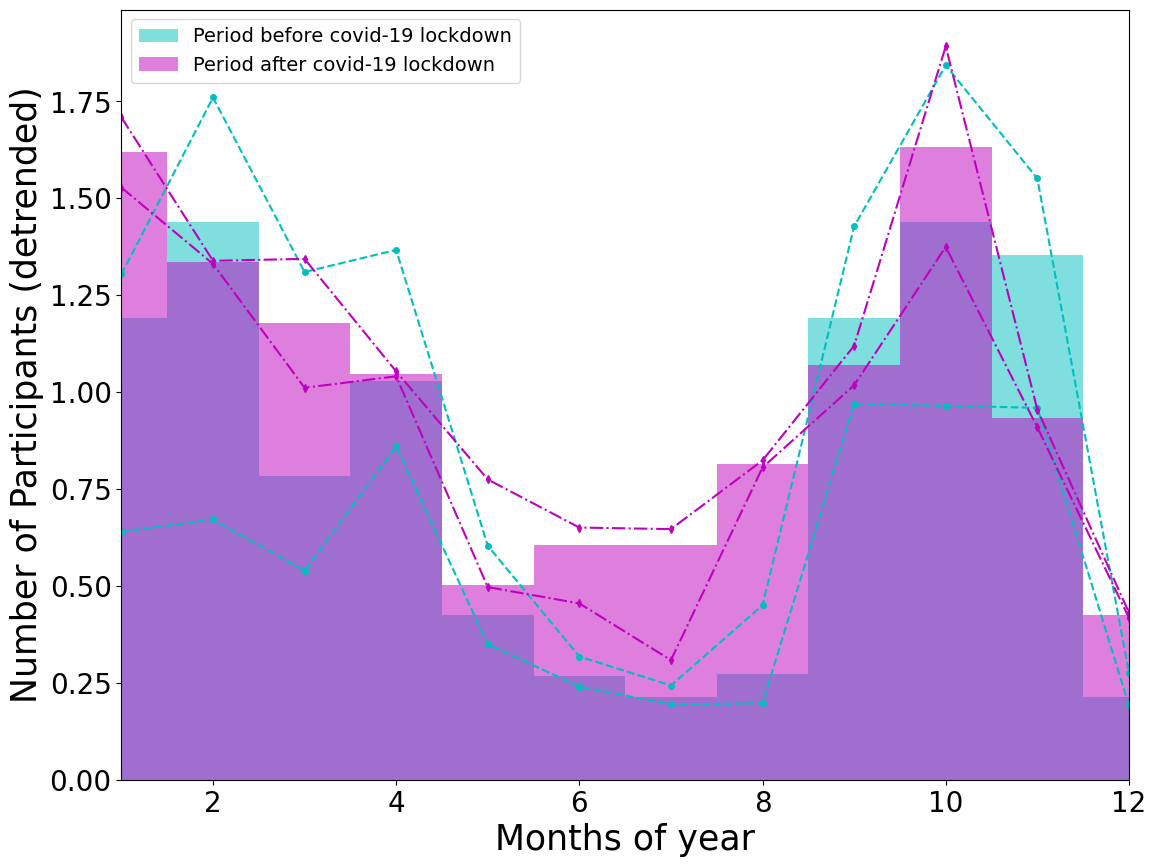

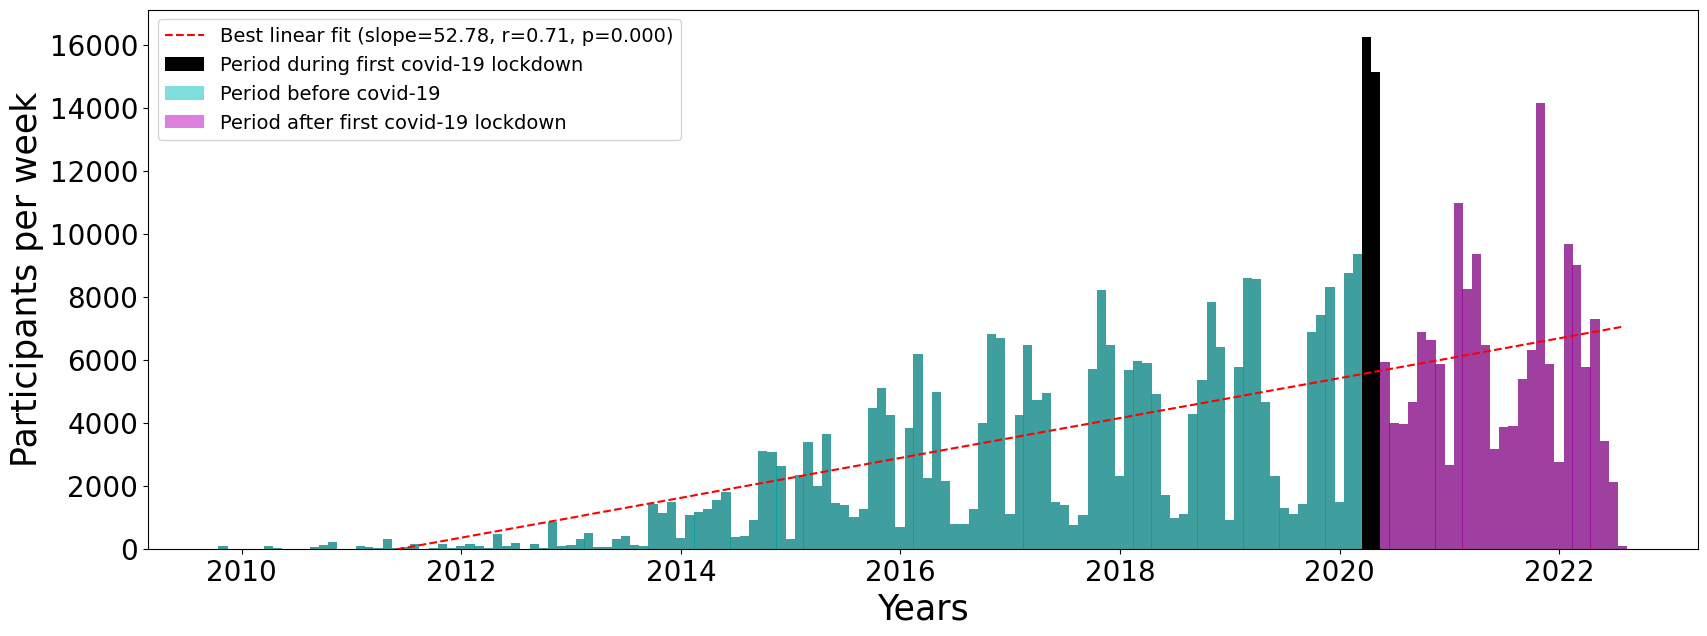

In [269]:
# Time Series + Monthly periodicity (monthly bins)

#build = pd.DatetimeIndex(df_hack_participants['timestamp'])

# Projects
df_hack_repos['datetimeindex'] = pd.DatetimeIndex(df_hack_repos['timestamp'])
#tseries_hacks = df_hack_repos.groupby(pd.Grouper(key='datetimeindex', freq='W')).size()

# Participants
df_hack_participants['datetimeindex'] = pd.DatetimeIndex(df_hack_participants['timestamp'])
tseries_hacks = df_hack_participants.groupby(pd.Grouper(key='datetimeindex', freq='W')).size()


dic = {'hack': {'df' : df_hack_time, 'label': "Hackathons",'t_start_covid19':125},
       'projects' :{'df' : df_hack_repos, 'label': "Projects",'t_start_covid19':125-14}, 
       'participants' : {'df' : df_hack_participants, 'label': "Participants",'t_start_covid19':125}
       }

pl.close()

for k,key in enumerate(dic.keys()):
    print(k,key)
    tseries_hacks = dic[key]['df'].groupby(pd.Grouper(key='datetimeindex', freq='M')).size()

    t_week = tseries_hacks.index
    print(len(t_week))
    hacks_per_week = tseries_hacks.values


    x = np.arange(0,len(t_week))
    y = hacks_per_week

    fit = S.linregress(x,y)
    print(fit)
    y_fit = x*fit[0]+fit[1]
    y_detrend = y/y_fit

    c0 = x > 20

    c_before_covid = x < dic[key]['t_start_covid19']
    c_after_covid = x > dic[key]['t_start_covid19'] + 1
    c_during_covid =  (x >= dic[key]['t_start_covid19'] )*( x <= dic[key]['t_start_covid19'] + 1)

    pl.figure(k+1,(13,10))
    months = t_week.month.values

    B = binning(months[c0*c_before_covid], y_detrend[c0*c_before_covid],np.arange(1,14),confinter=25)
    pl.bar(B['bins'],B['median'],width=1,alpha=0.5,color="c",label="Period before covid-19 lockdown")
    pl.plot(B['bins'],B['percUp'],'c--o',ms = 4)
    pl.plot(B['bins'],B['percDown'],'c--o',ms = 4)

    B = binning(months[c0*c_after_covid], y_detrend[c0*c_after_covid],np.arange(1,14),confinter=25)
    pl.bar(B['bins'],B['median'],width=1,alpha=0.5, color="m",label="Period after covid-19 lockdown")
    pl.plot(B['bins'],B['percUp'],'m-.d',ms = 4)
    pl.plot(B['bins'],B['percDown'],'m-.d',ms = 4)

    pl.legend(loc=0)

    pl.xlabel("Months of year")
    pl.ylabel("Number of %s (detrended)"%dic[key]['label'])
    pl.xlim(xmin=1,xmax=12)
    pl.savefig("output/figures/detrended_seasonality_%s.eps"%dic[key]['label'])


    pl.figure(k+4,(20,7))
    pl.bar(t_week,hacks_per_week,width=31,color='k',alpha=0.5)
    pl.bar(t_week[c_during_covid],hacks_per_week[c_during_covid],width=31,color='k',alpha=1, label="Period during first covid-19 lockdown")
    pl.bar(t_week[c_before_covid],hacks_per_week[c_before_covid],width=31,color='c',alpha=0.5,label="Period before covid-19")
    pl.bar(t_week[c_after_covid],hacks_per_week[c_after_covid],width=31,color='m',alpha=0.5, label="Period after first covid-19 lockdown")

    #pl.plot(x.index,x.values)
    pl.plot(t_week,x*fit[0]+fit[1],'r--',label="Best linear fit (slope=%.2f, r=%.2f, p=%.3f)"%(fit[0],fit[2],fit[3]))
    pl.legend(loc=0)
    pl.xlabel("Years")
    pl.ylabel("%s per week"%dic[key]['label'])
    pl.ylim(ymin=0)

    pl.savefig("output/figures/time_series_%s.eps"%dic[key]['label'])

'''
pl.figure(4,(21,5))

print(fit)
pl.bar(x,y,width=1)
pl.plot(x,x*fit[0]+fit[1],'r--')
pl.xlabel("years")
pl.ylabel("hackathons per week")

pl.figure(5,(21,5))

pl.bar(x,y_detrend,width=1)


pl.figure(6,(21,5))
pl.bar(t_week,y_detrend,width=7)

'''


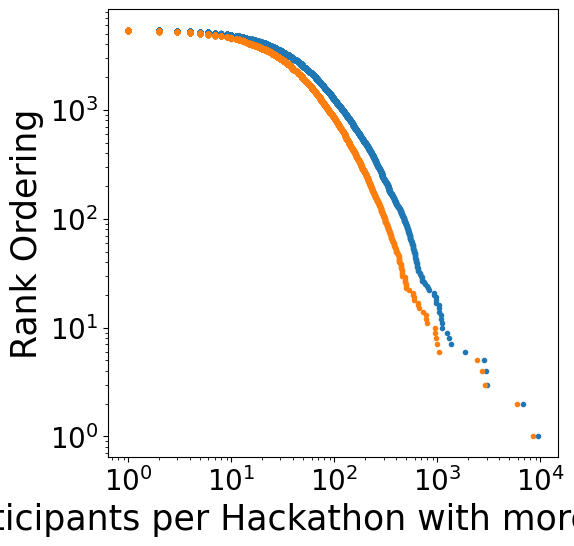

In [270]:
# Number of first hack participants per hack

n = 0
data = df_hack_participants[df_hack_participants['participation_increment']>n].groupby("hackathonID").count()['participantID'].values
x,y = rankorder(data)
pl.loglog(x,y,'.')
pl.xlabel("Number of Participants per Hackathon with more than %s hackathons"%n)
pl.ylabel("Rank Ordering")

data = df_hack_participants[df_hack_participants['participation_increment']==1].groupby("hackathonID").count()['participantID'].values
x,y = rankorder(data)
pl.loglog(x,y,'.')


0.7261517963023573 0.75


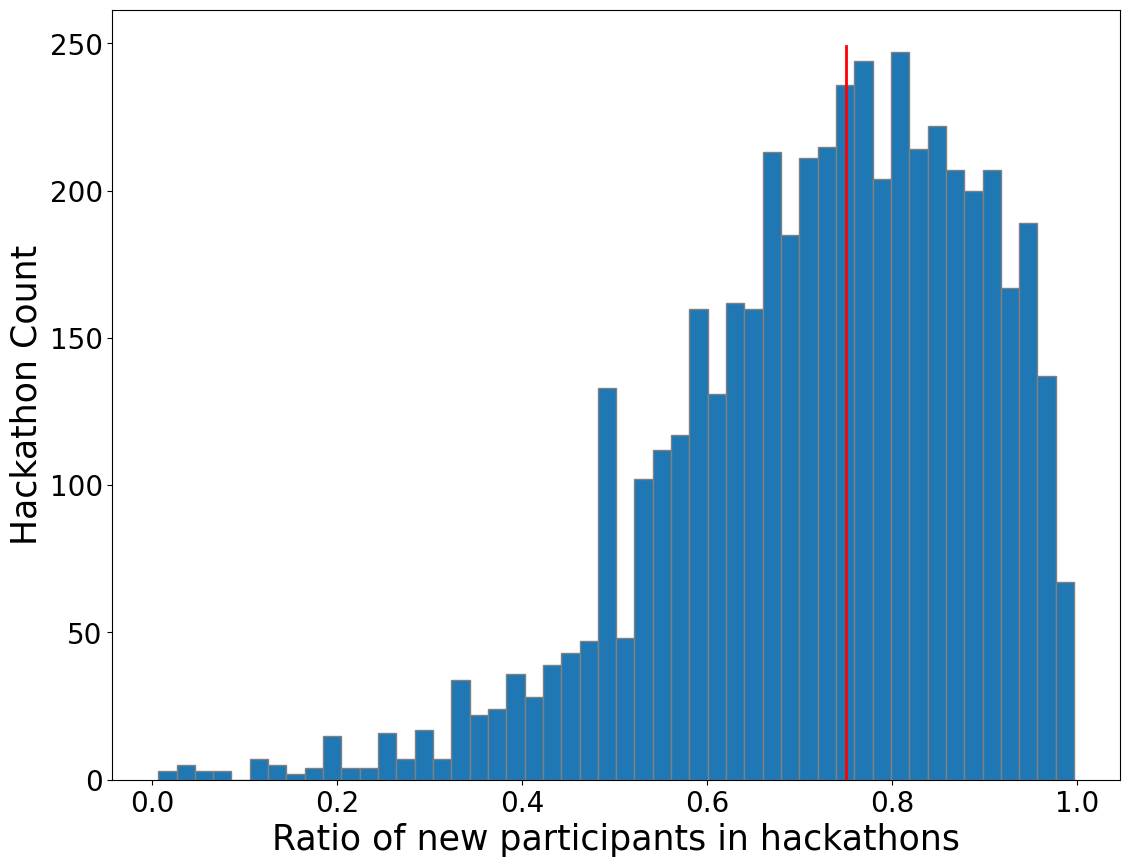

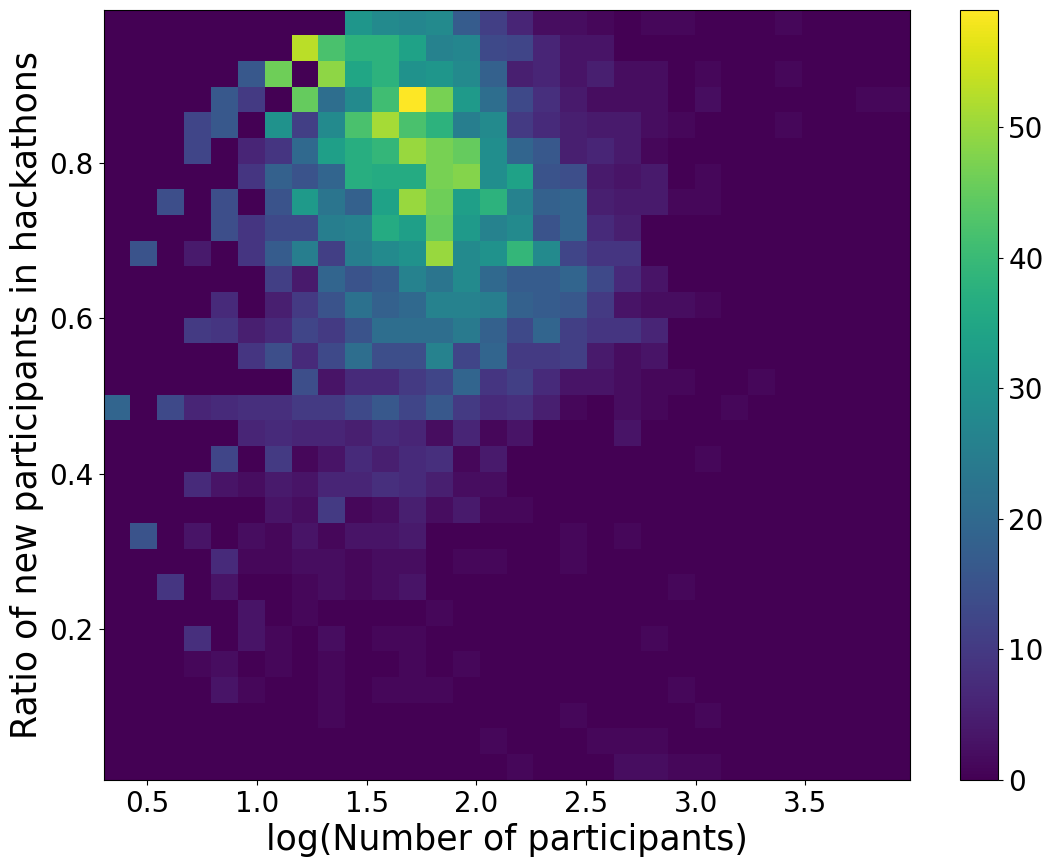

In [312]:
df_hack_participants = dicDF['df_hack_participants_sdg']

newbies = pd.DataFrame(df_hack_participants[df_hack_participants['participation_increment']<=1].groupby("hackathonID").count()['participantID']).rename(columns= {'participantID':'newbies'})
returning = pd.DataFrame(df_hack_participants[df_hack_participants['participation_increment']>1].groupby("hackathonID").count()['participantID']).rename(columns= {'participantID':'returning'})
hack_stats = pd.concat([newbies,returning],axis=1)
hack_stats['all'] = hack_stats['newbies'] + hack_stats['returning']
hack_stats['ratio'] = hack_stats['newbies']/hack_stats['all']

pl.figure(1,(13,10))
H = pl.hist(hack_stats['ratio'],bins = 50, histtype='bar', ec='grey',density=False)
mean_ratio = hack_stats['ratio'].mean()
median_ratio =  hack_stats['ratio'].median()
print(mean_ratio,median_ratio)
y = np.arange(0,250)
x = np.zeros_like(y)+median_ratio
pl.plot(x, y,'r-',lw=2)
pl.xlabel("Ratio of new participants in hackathons")
pl.ylabel("Hackathon Count")
pl.savefig("output/figures/ratio_new_participants.eps")

pl.figure(2,(13,10))
x = hack_stats['all']
y = hack_stats['ratio']

lx,ly = logify(x,y)

out = pl.hist2d(lx,10**ly,bins=30)
#pl.legend(loc=0)
pl.xlabel("log(Number of participants)")
pl.ylabel("Ratio of new participants in hackathons")
pl.colorbar()
pl.savefig("output/figures/heatmap_new_participants.eps")



Text(0, 0.5, 'Rank Ordering')

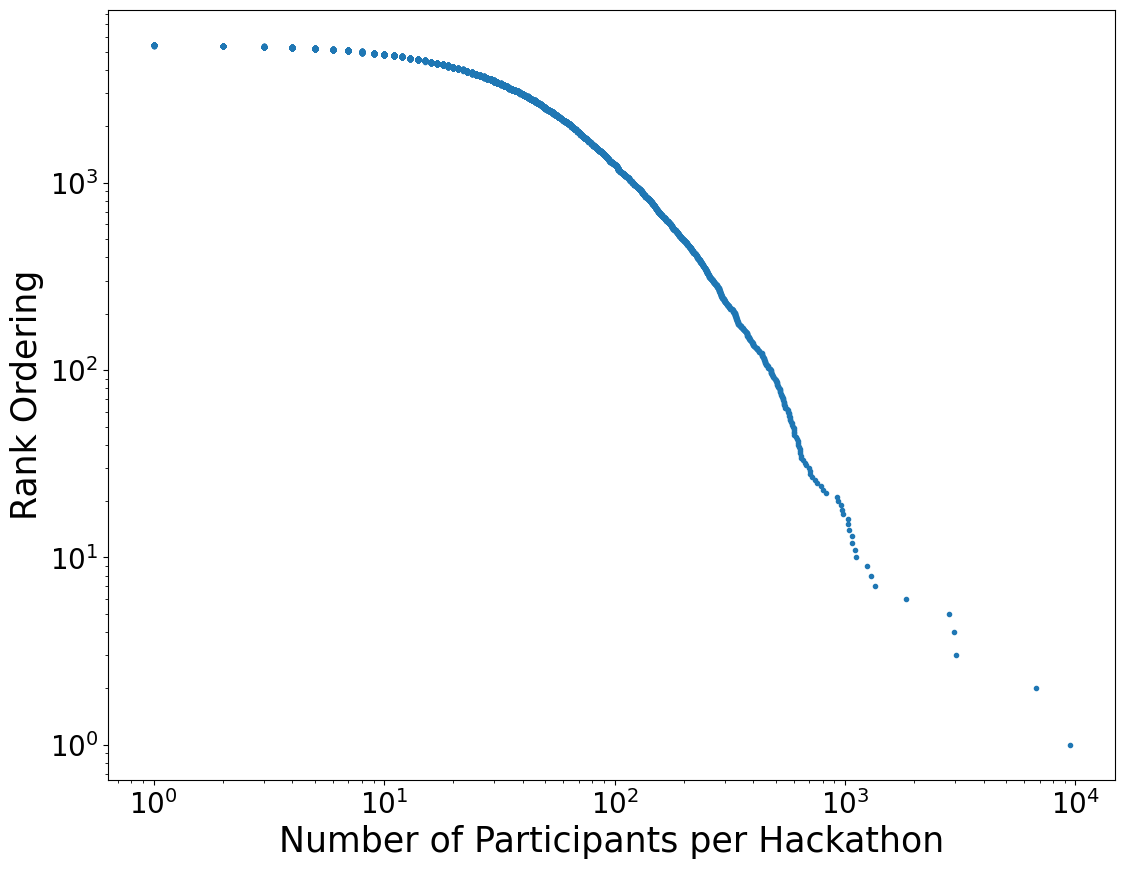

In [296]:
### Distribution of Participants per Hackathon
participation_to_hack = df_hack_participants.groupby("hackathonID").count()['participantID'].values
x,y = rankorder(participation_to_hack)
pl.figure(1,(13,10))
pl.loglog(x,y,'.')
pl.xlabel("Number of Participants per Hackathon")
pl.ylabel("Rank Ordering")

2.3774598053890124 4.95779916931648 -562700.8954705847 0.027101365739985447 9.844222634552624e-05


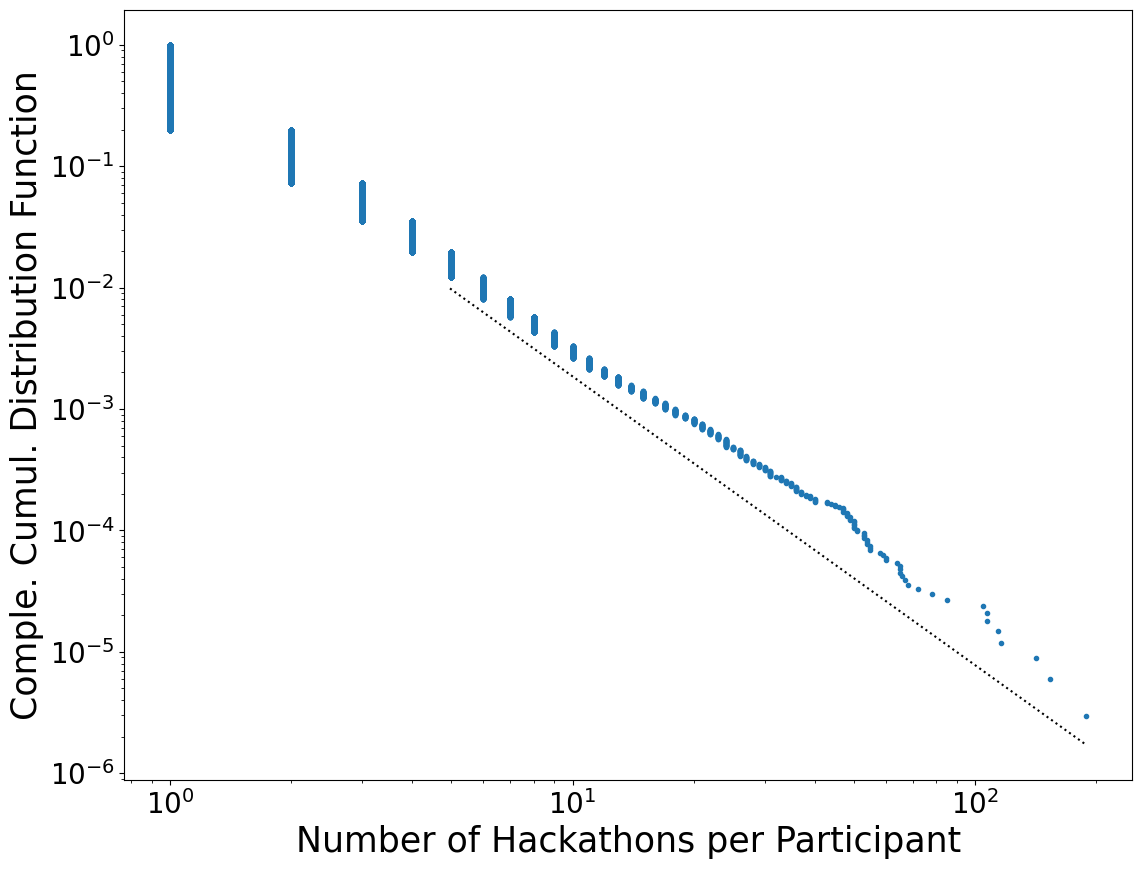

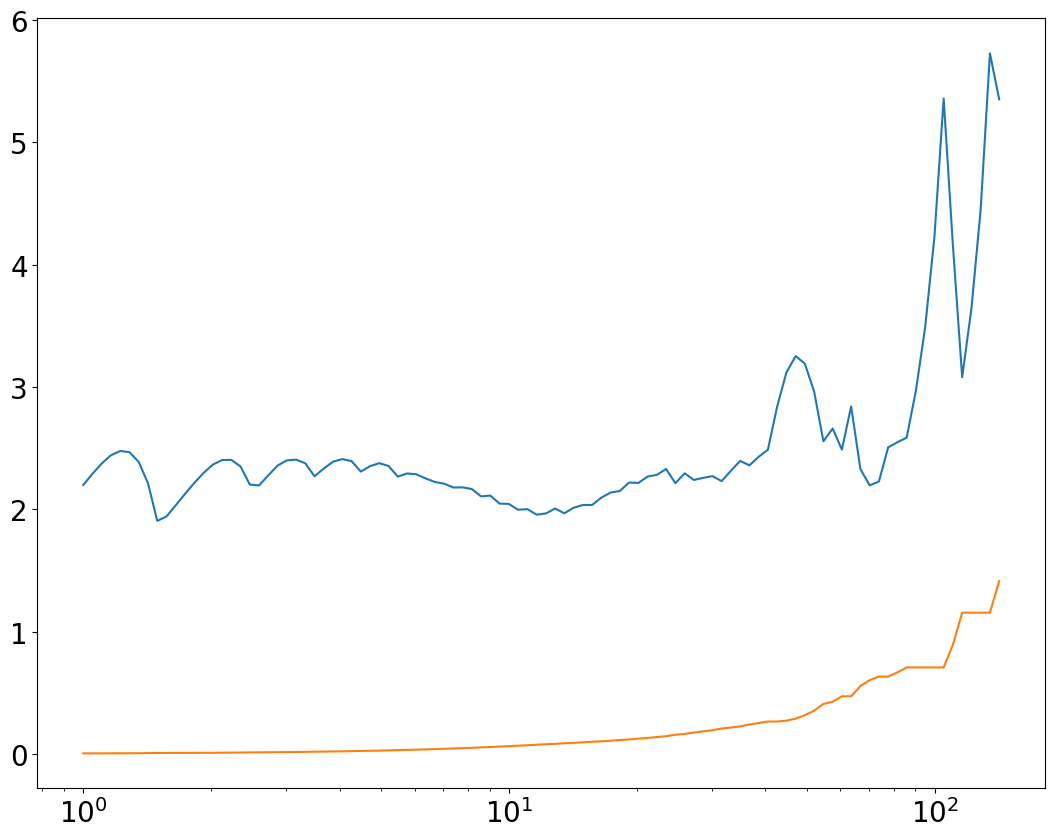

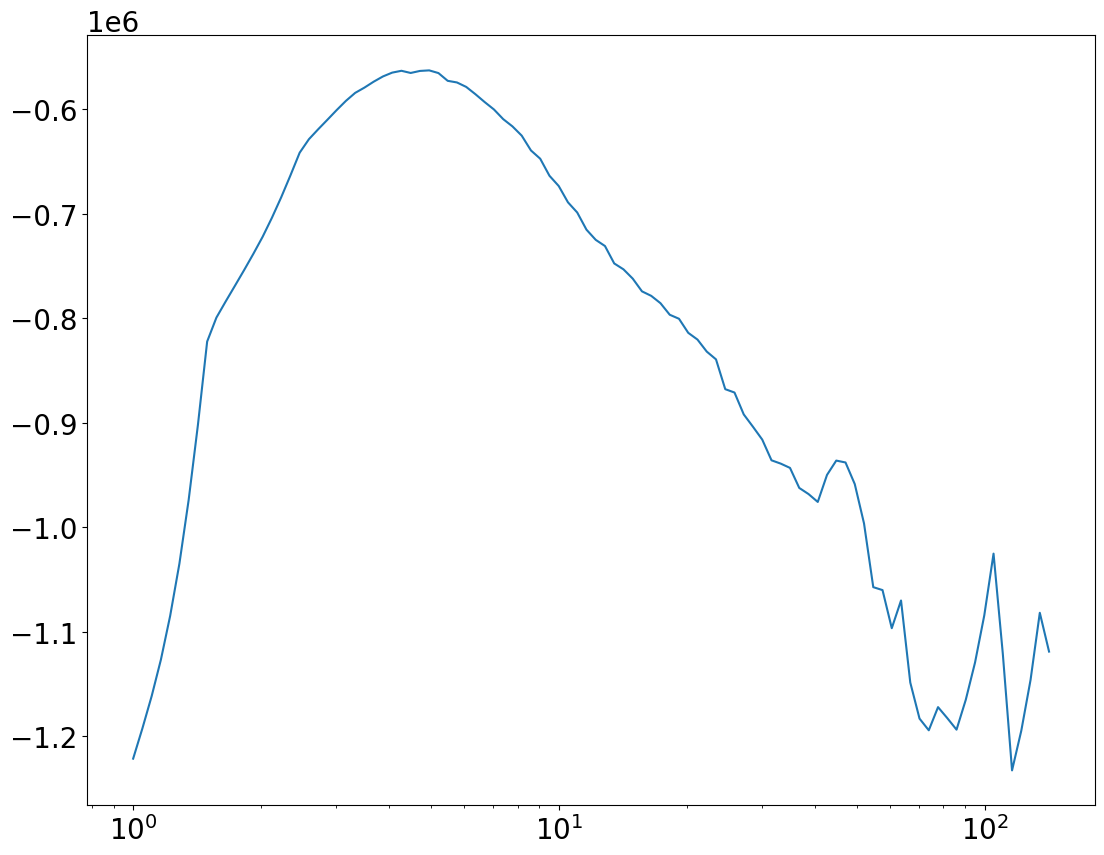

In [392]:
### Distribution of Hackathons Per Participant

hack_participations = df_hack_participants.groupby("participantID").count().sort_values(["hackathonID"],ascending=False)['hackathonID'].values
x,y = rankorder(hack_participations)
data = x
data_rand = data + (np.random.rand(len(data)) - 0.5)
index,mu,error,llh,points = vary_threshold(data_rand,xmin=1,index=100,type='cont')

i_max_llh = np.argmax(llh)
y_norm = y/y[-1]
y_norm_min = y_norm[i_max_llh]
print(mu[i_max_llh],index[i_max_llh],llh[i_max_llh],error[i_max_llh],y_norm_min)

pl.figure(1,(13,10))
xFit = np.logspace(np.log10(index[i_max_llh]),np.log10(max(x)))
yFit = y_norm_min*100/(xFit/float(index[i_max_llh]))**mu[i_max_llh]
pl.loglog(xFit,yFit,'k:')
pl.loglog(x,y_norm,'.')
pl.xlabel("Number of Hackathons per Participant")
pl.ylabel("Comple. Cumul. Distribution Function")
pl.savefig("output/figures/CCDF_hacks_participants.eps")



pl.figure(2,(13,10))
pl.semilogx(index,mu)
pl.semilogx(index,error)
pl.figure(3,(13,10))
pl.semilogx(index,llh)

In [299]:
projects = df.projectID.value_counts().sort_values(ascending=[False]).values
hackathons = df.hackathonID.value_counts().sort_values(ascending=[False]).values

count_projects_per_hack = df.groupby(['hackathonID','start_timestamp'])['projectID'].count().values
count_participants_per_hack = df.groupby(['hackathonID','start_timestamp'])['number_participants_per_project'].sum().values

1.8680458331607932 119.23570047386919 0.001282991202346041


Text(0, 0.5, 'Rank Ordering')

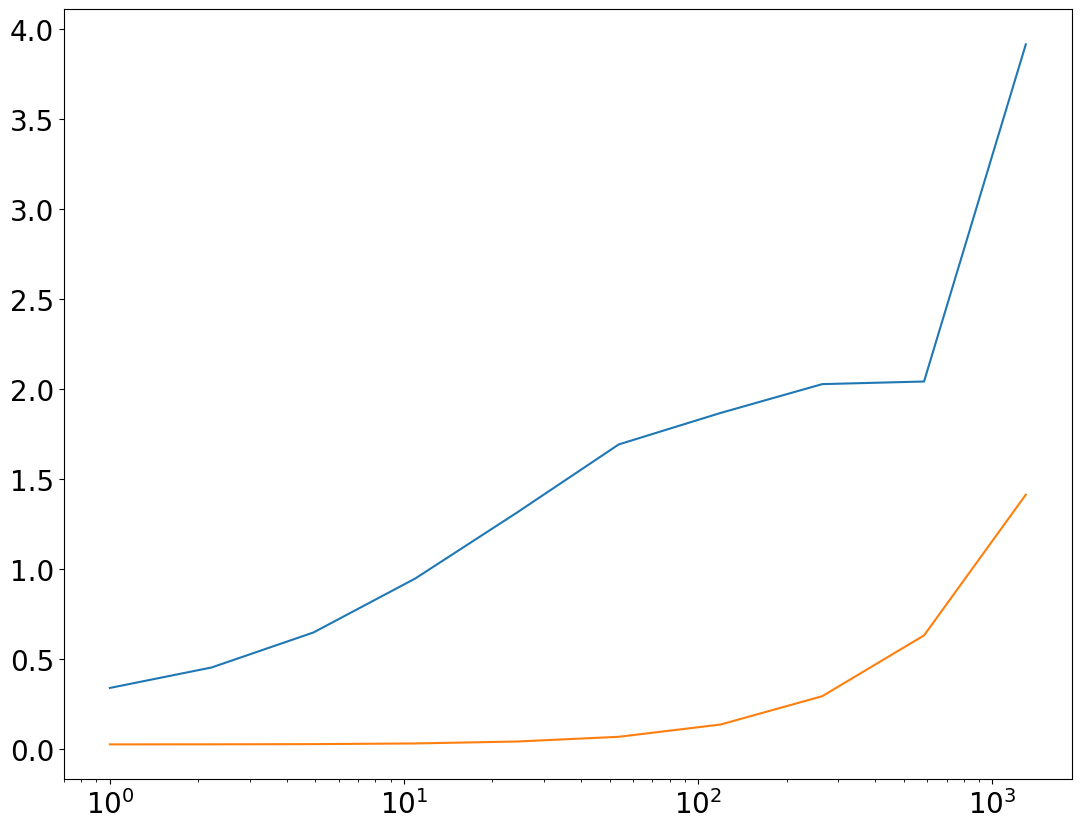

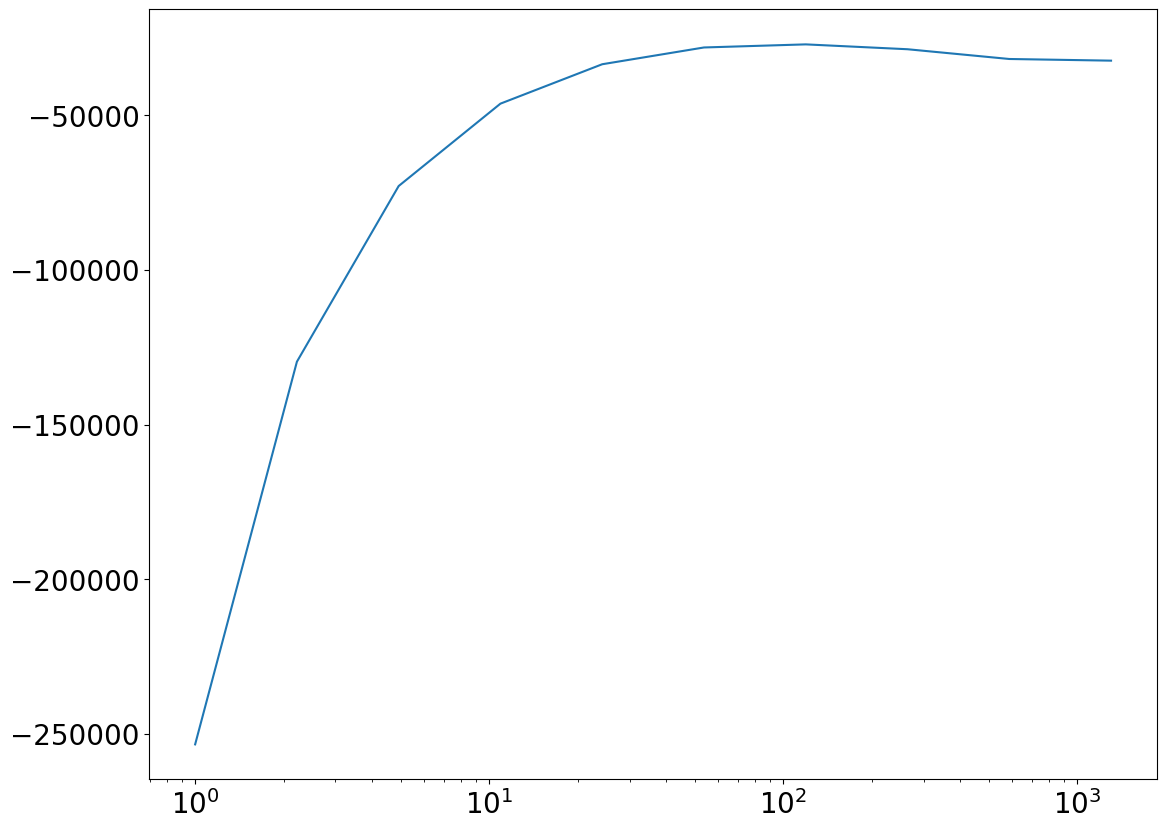

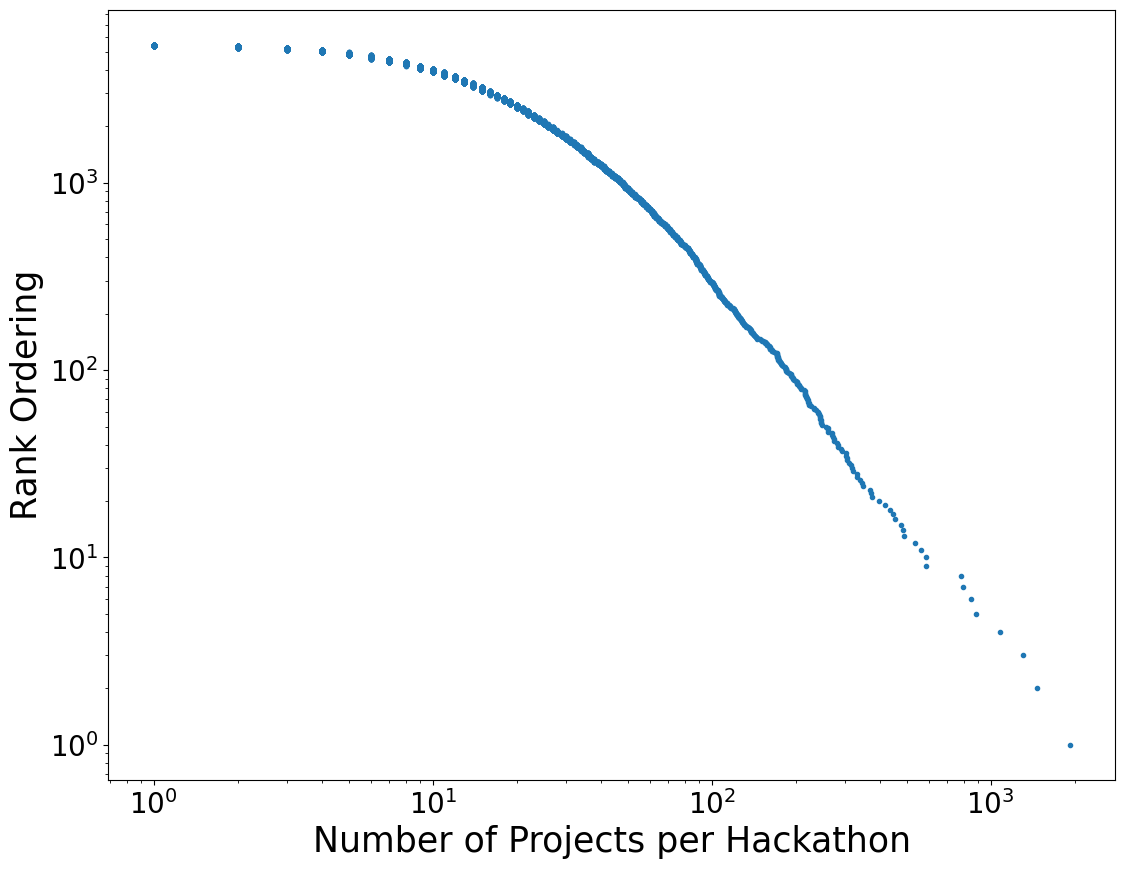

In [386]:
x,y = rankorder(hackathons)
data = x

data_rand = data + (np.random.rand(len(data)) - 0.5)
index,mu,error,llh,points = vary_threshold(data_rand,xmin=1,index=10,type='cont')

i_max_llh = np.argmax(llh)
y_norm = y/y[-1]
y_norm_min = y_norm[i_max_llh]
print(mu[i_max_llh],index[i_max_llh],y_norm_min)


pl.figure(2,(13,10))
pl.semilogx(index,mu)
pl.semilogx(index,error)

pl.figure(3,(13,10))
pl.semilogx(index,llh)


pl.figure(1,(13,10))
pl.loglog(x,y,'.')
pl.xlabel("Number of Projects per Hackathon")
pl.ylabel("Rank Ordering")

Text(0, 0.5, 'Rank Ordering')

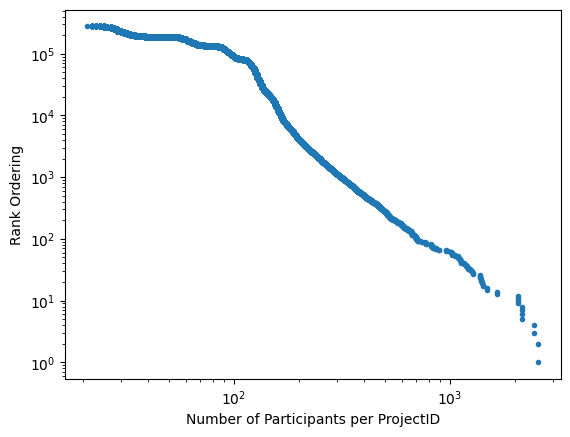

In [87]:
number_participants = df['number_participants'].values
cond = ~np.isnan(number_participants)

x,y = rankorder(number_participants[cond])
pl.loglog(x,y,'.')
pl.xlabel("Number of Participants per ProjectID")
pl.ylabel("Rank Ordering")

LinregressResult(slope=0.9370724471611273, intercept=-1.691509453603814, rvalue=0.9008996371631798, pvalue=0.0, stderr=0.008041200078549636, intercept_stderr=0.02736379989852197)
LinregressResult(slope=0.8310992060071428, intercept=-1.2652106739191908, rvalue=0.9967816798117553, pvalue=1.0213692420135111e-26, stderr=0.013936984548103125, intercept_stderr=0.049377553727110925)
LinregressResult(slope=1.0455035443265865, intercept=1.767938806648618, rvalue=0.9924121685686024, pvalue=2.3138011011007663e-23, stderr=0.02644090024325069, intercept_stderr=0.05203125531806685)


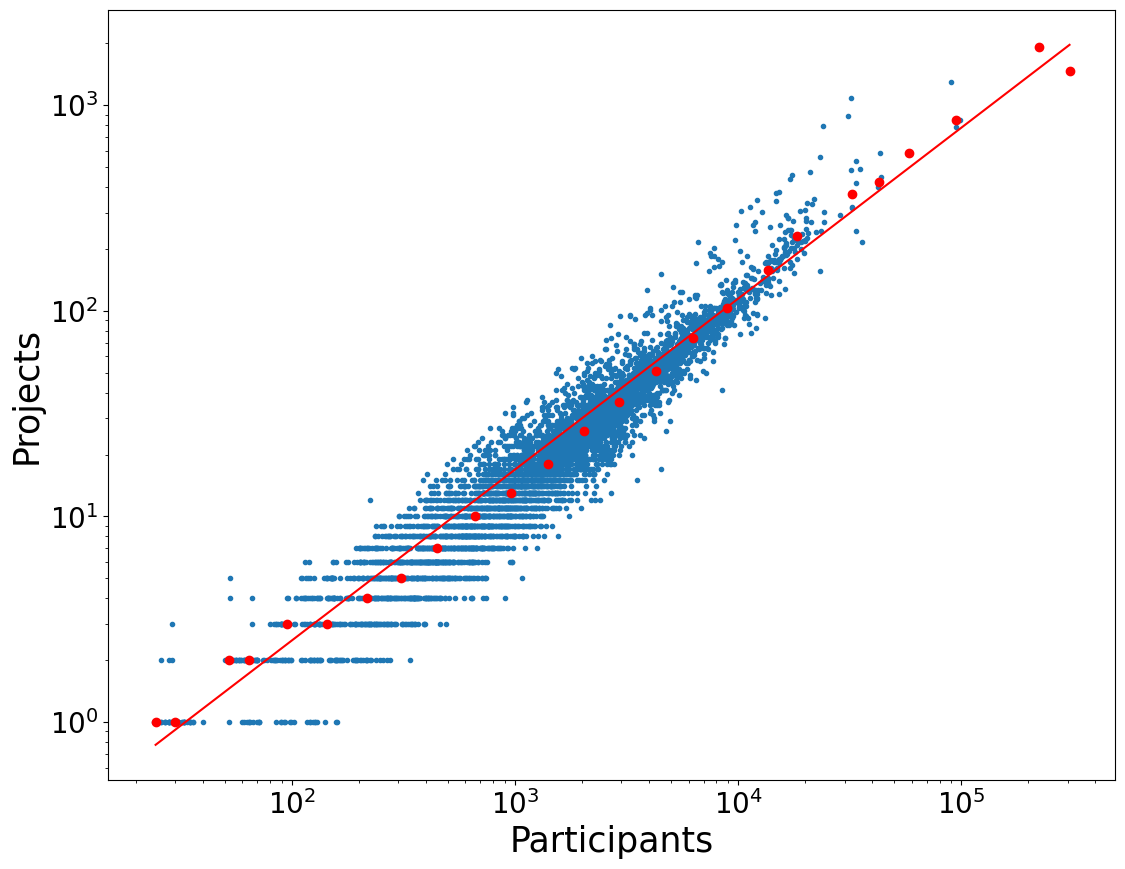

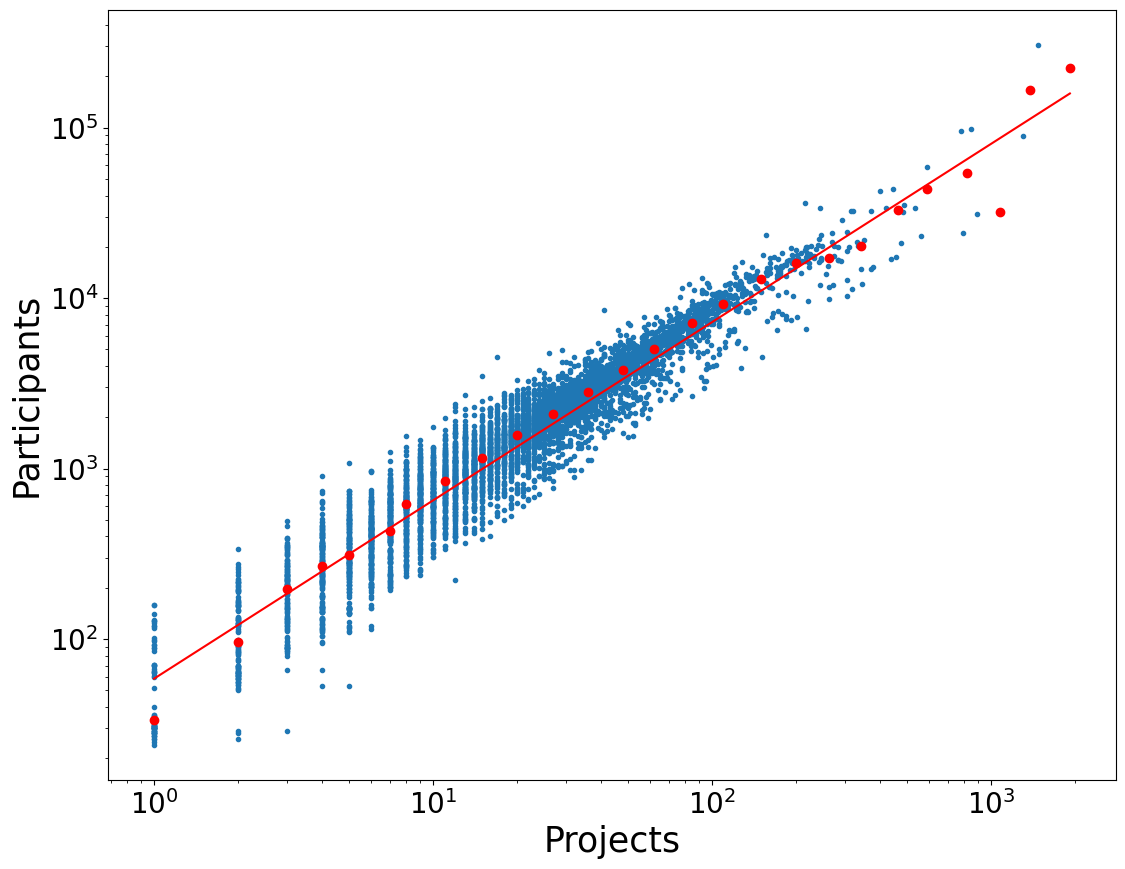

In [319]:
x = count_participants_per_hack; y = count_projects_per_hack

lx,ly = logify(x,y)

cond = (lx > 3 )*(lx < 4)
fit = S.linregress(lx[cond],ly[cond])
print(fit)

pl.figure(1,(13,10))
pl.loglog(count_participants_per_hack,count_projects_per_hack,'.')
#pl.loglog(10**lx,10**(fit[0]*lx + fit[1]),'k-')

pl.xlabel("Participants")
pl.ylabel("Projects")


B = binning(lx,ly,30,log_10=False)
fitB = S.linregress(B['bins'],B['median'])
print(fitB)

pl.loglog(10**B['bins'],10**B['median'],'ro')
#pl.loglog(10**B['bins'],10**B['percUp'],'r-.')
#pl.loglog(10**B['bins'],10**B['percDown'],'r-.')
pl.loglog(10**B['bins'],10**(B['bins']*fitB[0] + fitB[1]),'r-')




pl.figure(2,(13,10))
pl.loglog(count_projects_per_hack,count_participants_per_hack,'.')
#pl.loglog(10**lx,10**(fit[0]*lx + fit[1]),'k-')

pl.xlabel("Projects")
pl.ylabel("Participants")


#lx,ly = logify(x,y)
cond = (lx > 3 )*(lx < 4)

B = binning(ly,lx,30,log_10=False)
fitB = S.linregress(B['bins'],B['median'])
print(fitB)

pl.loglog(10**B['bins'],10**B['median'],'ro')
#pl.loglog(10**B['bins'],10**B['percUp'],'r-.')
#pl.loglog(10**B['bins'],10**B['percDown'],'r-.')
pl.loglog(10**B['bins'],10**(B['bins']*fitB[0] + fitB[1]),'r-')
pl.savefig("output/figures/productivity_projects_participants.eps")




### Old Stuff

In [4]:
#Not sure if still useful

save = False
projectIDs = np.unique(df.projectID)
dfprojects = pd.DataFrame(columns=['projectID','dates'])

for project in tqdm(projectIDs):
    dates = df[df['projectID']==project]['start_timestamp'].values
    dfprojects.loc[len(dfprojects)] = [project,dates]


if save:
    dfprojects.to_pickle("data/project_dates.pkl")

  0%|          | 868/184406 [00:06<22:04, 138.56it/s]


KeyboardInterrupt: 

In [143]:
# No longer useful

listJD = []
projects = df['projectID'].values




#for project in tqdm(projects[:]):
for i,project in enumerate(projects[:]):
    
    #team_old= [];team = []
    participants = df[df['projectID']==project]['participants_vector']
    steps = len(participants)

    try:
        np.unique(participants)
    except:
        listJD.append(np.nan)
        continue


    if steps < 2 or pd.isna(participants.values[0]) or len(np.unique(participants))==1:
        listJD.append(np.nan)
        continue
    else:
        Participants = participants

    print("%s/%s :%s"%(i,len(projects),project))

    J = []
    for i in range(0,steps-1):
        team_next = [x[20:] for x in re.sub(" ","",participants.iloc[i]).split(",")]
        team = [x[20:] for x in re.sub(" ","",participants.iloc[i+1]).split(",")]
        j = 1 - jaccard(team,team_next)
        J.append(j)
        if i > 0:
            print("%0.2f"%j,team,team_next)
    #print("")
    #print(participants)

    listJD.append(J)

    print("")

df['jaccard_distance'] = listJD

1941/283270 :https://devpost.com/software/create-a-connect-four-game-u18glh
0.25 ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792'] ['craig-roberts-152', 'jainabhinandan-19', 'rohansharma4792']
0.00 ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792'] ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792']

1942/283270 :https://devpost.com/software/connect-four-1ix7hy
0.50 ['aayushibansal2001', 'anantbansal2003'] ['aayushibansal2001']
0.00 ['aayushibansal2001', 'anantbansal2003'] ['aayushibansal2001', 'anantbansal2003']

1946/283270 :https://devpost.com/software/learn-about-apis-dt6xpo
0.25 ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792'] ['craig-roberts-152', 'jainabhinandan-19', 'rohansharma4792']
0.00 ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792'] ['craig-roberts-152', 'jainabhinandan-19', 'khusheee20', 'rohansharma4792']

1956/283270 :https://devpost.com/softw

In [38]:
def addition_based_jaccard_similarity(set_a, set_b):
    """
    Calculates the Addition-Based Jaccard Similarity between two sets.

    Args:
        set_a (set): First input set.
        set_b (set): Second input set.

    Returns:
        float: Addition-Based Jaccard Similarity value.
    """
    intersection = len(set_a & set_b)  # Common elements
    union = len(set_a | set_b)  # Union of sets
    additions_a = len(set_a - set_b)  # Elements in set_a but not in set_b
    additions_b = len(set_b - set_a)  # Elements in set_b but not in set_a

    denominator = union + additions_a + additions_b
    similarity = intersection / denominator

    return similarity

# Example usage:
set1 = {1, 2, 3, 4}
set2 = {3, 4, 5, 6}
similarity_value = addition_based_jaccard_similarity(set1, set2)
print(f"Addition-Based Jaccard Similarity: {similarity_value:.4f}")

Addition-Based Jaccard Similarity: 0.2000


In [52]:
set_a = {1,2,3,4}
set_b = {1,3,4,6,7,8,8}

addition_based_jaccard_similarity(set_a, set_b)

0.2727272727272727